Use kernel conda_tensorflow_p36

In [1]:
import datetime as dt
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.regularizers import L1L2

plt.style.use('ggplot')

Using TensorFlow backend.


## Define helper functions

In [2]:
# Function to replace every NULL column with the mean from the training set (Naive Bayes)
def replace_nans_mean(df, split_date):
    split_idx = np.max(df.loc[df['date']<split_date].index.values)
    df_cp = df.copy()
    for col in df_cp.columns:
        if col == 'date':
            continue
        naive_estimate = df_cp.loc[:split_idx, col].mean()
        df_cp.loc[pd.isnull(df_cp[col]), col] = naive_estimate
        
    return df_cp

# Function to build 3-dimensional ndarray for LSTM based on input df and lookback window
def build_lstm_data(df, window):
    X = []
    y = []
    for i in range(len(df)-window):
        temp_set = df[i:(i+window)].copy()
        X.append(temp_set[:,1:])
        y.append(temp_set[window-1,0])

    return np.array(X), np.array(y)

## Tom Brady

In [3]:
# Read in data
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')

# Select features for RNN, along with target. Specifically, remove averages.
features = [
    'target',
    'date',
    'player_played',
    'player_home',
    'betting_over_under_line',
    'betting_spread',
    'weather_temperature',
    'weather_wind_mph',
    'weather_humidity',
    'weather_inclement',
    'defense_fumbles_forced_moving_avg_1',
    'defense_fumbles_forced_moving_avg_3',
    'defense_fumbles_forced_moving_avg_5',
    'defense_interceptions_moving_avg_1',
    'defense_interceptions_moving_avg_3',
    'defense_interceptions_moving_avg_5',
    'defense_pass_yards_allowed_moving_avg_1',
    'defense_pass_yards_allowed_moving_avg_3',
    'defense_pass_yards_allowed_moving_avg_5',
    'defense_rush_yards_allowed_moving_avg_1',
    'defense_rush_yards_allowed_moving_avg_3',
    'defense_rush_yards_allowed_moving_avg_5',
    'defense_sacks_moving_avg_1',
    'defense_sacks_moving_avg_3',
    'defense_sacks_moving_avg_5',
    'defense_points_allowed_moving_avg_1',
    'defense_points_allowed_moving_avg_3',
    'defense_points_allowed_moving_avg_5'
]

brady = brady.loc[:, features]
brady['date'] = pd.to_datetime(brady['date'])

In [4]:
split_date = pd.Timestamp(2012,5,1)        
brady = replace_nans_mean(brady, split_date)

In [5]:
# Train + test set indices
train_idx = brady.loc[brady['date']<split_date].index.values
test_idx = brady.loc[brady['date']>split_date].index.values

# Scale Features
brady.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(brady)
brady = scaler.transform(brady)

# Train + test sets
train, test = brady[train_idx], brady[test_idx]

# Split to X and Y
# X_train, X_test, y_train, y_test = X, y = brady.iloc[:,1:], brady.iloc[:,0]

In [6]:
# Create train and test sets
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [7]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [10]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, bias_regularizer=L1L2(0.01,0.01)))
    model.add(Dropout(.3))
    model.add(LSTM(30))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=250, batch_size=5, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()
    

Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.3355 - val_loss: 2.2045
Epoch 2/250
 - 0s - loss: 2.2519 - val_loss: 2.2654
Epoch 3/250
 - 0s - loss: 2.2558 - val_loss: 2.1754
Epoch 4/250
 - 0s - loss: 2.1969 - val_loss: 2.1363
Epoch 5/250
 - 0s - loss: 2.1663 - val_loss: 2.1125
Epoch 6/250
 - 0s - loss: 2.1756 - val_loss: 2.0972
Epoch 7/250
 - 0s - loss: 2.0962 - val_loss: 2.0914
Epoch 8/250
 - 0s - loss: 2.1195 - val_loss: 2.0990
Epoch 9/250
 - 0s - loss: 2.1150 - val_loss: 2.1038
Epoch 10/250
 - 0s - loss: 2.1172 - val_loss: 2.0665
Epoch 11/250
 - 0s - loss: 2.0790 - val_loss: 2.0301
Epoch 12/250
 - 0s - loss: 2.0562 - val_loss: 2.0099
Epoch 13/250
 - 0s - loss: 2.0238 - val_loss: 1.9941
Epoch 14/250
 - 0s - loss: 2.0006 - val_loss: 1.9952
Epoch 15/250
 - 0s - loss: 1.9863 - val_loss: 1.9703
Epoch 16/250
 - 0s - loss: 1.9507 - val_loss: 1.9410
Epoch 17/250
 - 0s - loss: 1.9397 - val_loss: 1.9337
Epoch 18/250
 - 0s - loss: 1.9263 - val_loss: 1.9200
Epoch 19/25

Epoch 154/250
 - 0s - loss: 0.3703 - val_loss: 0.4877
Epoch 155/250
 - 0s - loss: 0.3681 - val_loss: 0.4347
Epoch 156/250
 - 0s - loss: 0.3484 - val_loss: 0.4673
Epoch 157/250
 - 0s - loss: 0.3378 - val_loss: 0.4450
Epoch 158/250
 - 0s - loss: 0.3442 - val_loss: 0.4398
Epoch 159/250
 - 0s - loss: 0.3286 - val_loss: 0.4331
Epoch 160/250
 - 0s - loss: 0.3477 - val_loss: 0.4834
Epoch 161/250
 - 0s - loss: 0.3221 - val_loss: 0.4094
Epoch 162/250
 - 0s - loss: 0.3492 - val_loss: 0.4055
Epoch 163/250
 - 0s - loss: 0.3048 - val_loss: 0.4534
Epoch 164/250
 - 0s - loss: 0.3380 - val_loss: 0.4314
Epoch 165/250
 - 0s - loss: 0.3412 - val_loss: 0.3817
Epoch 166/250
 - 0s - loss: 0.2947 - val_loss: 0.4355
Epoch 167/250
 - 0s - loss: 0.3295 - val_loss: 0.3801
Epoch 168/250
 - 0s - loss: 0.2874 - val_loss: 0.3561
Epoch 169/250
 - 0s - loss: 0.2750 - val_loss: 0.4021
Epoch 170/250
 - 0s - loss: 0.2842 - val_loss: 0.3630
Epoch 171/250
 - 0s - loss: 0.2433 - val_loss: 0.3410
Epoch 172/250
 - 0s - loss: 

 - 0s - loss: 1.3521 - val_loss: 1.3656
Epoch 57/250
 - 0s - loss: 1.2944 - val_loss: 1.3657
Epoch 58/250
 - 0s - loss: 1.2805 - val_loss: 1.3405
Epoch 59/250
 - 0s - loss: 1.2526 - val_loss: 1.3474
Epoch 60/250
 - 0s - loss: 1.2731 - val_loss: 1.2982
Epoch 61/250
 - 0s - loss: 1.2052 - val_loss: 1.2825
Epoch 62/250
 - 0s - loss: 1.2107 - val_loss: 1.3730
Epoch 63/250
 - 0s - loss: 1.2205 - val_loss: 1.2934
Epoch 64/250
 - 0s - loss: 1.1695 - val_loss: 1.2624
Epoch 65/250
 - 0s - loss: 1.1765 - val_loss: 1.2827
Epoch 66/250
 - 0s - loss: 1.1650 - val_loss: 1.2390
Epoch 67/250
 - 0s - loss: 1.1428 - val_loss: 1.2124
Epoch 68/250
 - 0s - loss: 1.1312 - val_loss: 1.2366
Epoch 69/250
 - 0s - loss: 1.1222 - val_loss: 1.2100
Epoch 70/250
 - 0s - loss: 1.1113 - val_loss: 1.2181
Epoch 71/250
 - 0s - loss: 1.1065 - val_loss: 1.2278
Epoch 72/250
 - 0s - loss: 1.0853 - val_loss: 1.1539
Epoch 73/250
 - 0s - loss: 1.1375 - val_loss: 1.1637
Epoch 74/250
 - 0s - loss: 1.0755 - val_loss: 1.1767
Epoch 

Epoch 209/250
 - 0s - loss: 0.0908 - val_loss: 0.1905
Epoch 210/250
 - 0s - loss: 0.0935 - val_loss: 0.1868
Epoch 211/250
 - 0s - loss: 0.0935 - val_loss: 0.2435
Epoch 212/250
 - 0s - loss: 0.1176 - val_loss: 0.2171
Epoch 213/250
 - 0s - loss: 0.1047 - val_loss: 0.1919
Epoch 214/250
 - 0s - loss: 0.0906 - val_loss: 0.2478
Epoch 215/250
 - 0s - loss: 0.0994 - val_loss: 0.2079
Epoch 216/250
 - 0s - loss: 0.1356 - val_loss: 0.1861
Epoch 217/250
 - 0s - loss: 0.0939 - val_loss: 0.2247
Epoch 218/250
 - 0s - loss: 0.1107 - val_loss: 0.2653
Epoch 219/250
 - 0s - loss: 0.1049 - val_loss: 0.1855
Epoch 220/250
 - 0s - loss: 0.0991 - val_loss: 0.1823
Epoch 221/250
 - 0s - loss: 0.0594 - val_loss: 0.2423
Epoch 222/250
 - 0s - loss: 0.0746 - val_loss: 0.2019
Epoch 223/250
 - 0s - loss: 0.0775 - val_loss: 0.2413
Epoch 224/250
 - 0s - loss: 0.0815 - val_loss: 0.2151
Epoch 225/250
 - 0s - loss: 0.0680 - val_loss: 0.2529
Epoch 226/250
 - 0s - loss: 0.1095 - val_loss: 0.2707
Epoch 227/250
 - 0s - loss: 

Epoch 112/250
 - 0s - loss: 0.6859 - val_loss: 0.7299
Epoch 113/250
 - 0s - loss: 0.6791 - val_loss: 0.7728
Epoch 114/250
 - 0s - loss: 0.6946 - val_loss: 0.7354
Epoch 115/250
 - 0s - loss: 0.6643 - val_loss: 0.7041
Epoch 116/250
 - 0s - loss: 0.6482 - val_loss: 0.7293
Epoch 117/250
 - 0s - loss: 0.6363 - val_loss: 0.7242
Epoch 118/250
 - 0s - loss: 0.6248 - val_loss: 0.6861
Epoch 119/250
 - 0s - loss: 0.5970 - val_loss: 0.6909
Epoch 120/250
 - 0s - loss: 0.5902 - val_loss: 0.6832
Epoch 121/250
 - 0s - loss: 0.6032 - val_loss: 0.6826
Epoch 122/250
 - 0s - loss: 0.6037 - val_loss: 0.7535
Epoch 123/250
 - 0s - loss: 0.6146 - val_loss: 0.6706
Epoch 124/250
 - 0s - loss: 0.5903 - val_loss: 0.6872
Epoch 125/250
 - 0s - loss: 0.5595 - val_loss: 0.6674
Epoch 126/250
 - 0s - loss: 0.5575 - val_loss: 0.6674
Epoch 127/250
 - 0s - loss: 0.5410 - val_loss: 0.6661
Epoch 128/250
 - 0s - loss: 0.5478 - val_loss: 0.6193
Epoch 129/250
 - 0s - loss: 0.5609 - val_loss: 0.6306
Epoch 130/250
 - 0s - loss: 

Epoch 14/250
 - 0s - loss: 1.9916 - val_loss: 1.9755
Epoch 15/250
 - 0s - loss: 1.9674 - val_loss: 1.9575
Epoch 16/250
 - 0s - loss: 1.9856 - val_loss: 1.9456
Epoch 17/250
 - 0s - loss: 1.9647 - val_loss: 1.9328
Epoch 18/250
 - 0s - loss: 1.8913 - val_loss: 1.9476
Epoch 19/250
 - 0s - loss: 1.9322 - val_loss: 1.9145
Epoch 20/250
 - 0s - loss: 1.8473 - val_loss: 1.9443
Epoch 21/250
 - 0s - loss: 1.8411 - val_loss: 1.8942
Epoch 22/250
 - 0s - loss: 1.8296 - val_loss: 1.8604
Epoch 23/250
 - 0s - loss: 1.7900 - val_loss: 1.8697
Epoch 24/250
 - 0s - loss: 1.7900 - val_loss: 1.8298
Epoch 25/250
 - 0s - loss: 1.7856 - val_loss: 1.8707
Epoch 26/250
 - 0s - loss: 1.7563 - val_loss: 1.8003
Epoch 27/250
 - 0s - loss: 1.7452 - val_loss: 1.7912
Epoch 28/250
 - 0s - loss: 1.7268 - val_loss: 1.7913
Epoch 29/250
 - 0s - loss: 1.7150 - val_loss: 1.7511
Epoch 30/250
 - 0s - loss: 1.7114 - val_loss: 1.7370
Epoch 31/250
 - 0s - loss: 1.6838 - val_loss: 1.7749
Epoch 32/250
 - 0s - loss: 1.6665 - val_loss: 

Epoch 168/250
 - 0s - loss: 0.3245 - val_loss: 0.3522
Epoch 169/250
 - 0s - loss: 0.2837 - val_loss: 0.3906
Epoch 170/250
 - 0s - loss: 0.2814 - val_loss: 0.3720
Epoch 171/250
 - 0s - loss: 0.2453 - val_loss: 0.3506
Epoch 172/250
 - 0s - loss: 0.2739 - val_loss: 0.3631
Epoch 173/250
 - 0s - loss: 0.2738 - val_loss: 0.4309
Epoch 174/250
 - 0s - loss: 0.2531 - val_loss: 0.3369
Epoch 175/250
 - 0s - loss: 0.2202 - val_loss: 0.3415
Epoch 176/250
 - 0s - loss: 0.2219 - val_loss: 0.3659
Epoch 177/250
 - 0s - loss: 0.2301 - val_loss: 0.3158
Epoch 178/250
 - 0s - loss: 0.2584 - val_loss: 0.3215
Epoch 179/250
 - 0s - loss: 0.2258 - val_loss: 0.4486
Epoch 180/250
 - 0s - loss: 0.2461 - val_loss: 0.2960
Epoch 181/250
 - 0s - loss: 0.2808 - val_loss: 0.2840
Epoch 182/250
 - 0s - loss: 0.2435 - val_loss: 0.3108
Epoch 183/250
 - 0s - loss: 0.2222 - val_loss: 0.3301
Epoch 184/250
 - 0s - loss: 0.2050 - val_loss: 0.2866
Epoch 185/250
 - 0s - loss: 0.2104 - val_loss: 0.2898
Epoch 186/250
 - 0s - loss: 

Epoch 71/250
 - 0s - loss: 1.1228 - val_loss: 1.2513
Epoch 72/250
 - 0s - loss: 1.1045 - val_loss: 1.1753
Epoch 73/250
 - 0s - loss: 1.0610 - val_loss: 1.1533
Epoch 74/250
 - 0s - loss: 1.0686 - val_loss: 1.2608
Epoch 75/250
 - 0s - loss: 1.0890 - val_loss: 1.1843
Epoch 76/250
 - 0s - loss: 1.0516 - val_loss: 1.1386
Epoch 77/250
 - 0s - loss: 1.0409 - val_loss: 1.1491
Epoch 78/250
 - 0s - loss: 1.0380 - val_loss: 1.0664
Epoch 79/250
 - 0s - loss: 1.0208 - val_loss: 1.1715
Epoch 80/250
 - 0s - loss: 0.9805 - val_loss: 1.0614
Epoch 81/250
 - 0s - loss: 1.0345 - val_loss: 1.0497
Epoch 82/250
 - 0s - loss: 0.9989 - val_loss: 1.1101
Epoch 83/250
 - 0s - loss: 1.0027 - val_loss: 1.0365
Epoch 84/250
 - 0s - loss: 0.9462 - val_loss: 1.0782
Epoch 85/250
 - 0s - loss: 0.9587 - val_loss: 1.0100
Epoch 86/250
 - 0s - loss: 0.9394 - val_loss: 1.0124
Epoch 87/250
 - 0s - loss: 0.9316 - val_loss: 1.0938
Epoch 88/250
 - 0s - loss: 0.9231 - val_loss: 1.0165
Epoch 89/250
 - 0s - loss: 0.9132 - val_loss: 

 - 0s - loss: 0.0648 - val_loss: 0.1762
Epoch 224/250
 - 0s - loss: 0.0753 - val_loss: 0.1903
Epoch 225/250
 - 0s - loss: 0.0495 - val_loss: 0.1952
Epoch 226/250
 - 0s - loss: 0.0693 - val_loss: 0.1918
Epoch 227/250
 - 0s - loss: 0.0610 - val_loss: 0.1696
Epoch 228/250
 - 0s - loss: 0.0647 - val_loss: 0.2244
Epoch 229/250
 - 0s - loss: 0.0953 - val_loss: 0.2341
Epoch 230/250
 - 0s - loss: 0.0750 - val_loss: 0.1705
Epoch 231/250
 - 0s - loss: 0.0562 - val_loss: 0.2011
Epoch 232/250
 - 0s - loss: 0.0719 - val_loss: 0.2062
Epoch 233/250
 - 0s - loss: 0.0553 - val_loss: 0.1820
Epoch 234/250
 - 0s - loss: 0.0584 - val_loss: 0.1972
Epoch 235/250
 - 0s - loss: 0.0657 - val_loss: 0.2239
Epoch 236/250
 - 0s - loss: 0.0647 - val_loss: 0.2142
Epoch 237/250
 - 0s - loss: 0.0753 - val_loss: 0.2640
Epoch 238/250
 - 0s - loss: 0.0778 - val_loss: 0.1876
Epoch 239/250
 - 0s - loss: 0.1237 - val_loss: 0.1671
Epoch 240/250
 - 0s - loss: 0.0990 - val_loss: 0.1905
Epoch 241/250
 - 0s - loss: 0.0787 - val_l

 - 0s - loss: 0.5715 - val_loss: 0.6121
Epoch 127/250
 - 0s - loss: 0.5716 - val_loss: 0.6260
Epoch 128/250
 - 0s - loss: 0.5307 - val_loss: 0.6299
Epoch 129/250
 - 0s - loss: 0.5175 - val_loss: 0.6222
Epoch 130/250
 - 0s - loss: 0.5385 - val_loss: 0.6125
Epoch 131/250
 - 0s - loss: 0.5198 - val_loss: 0.6124
Epoch 132/250
 - 0s - loss: 0.5572 - val_loss: 0.6015
Epoch 133/250
 - 0s - loss: 0.5132 - val_loss: 0.5615
Epoch 134/250
 - 0s - loss: 0.5035 - val_loss: 0.6414
Epoch 135/250
 - 0s - loss: 0.5082 - val_loss: 0.5786
Epoch 136/250
 - 0s - loss: 0.4843 - val_loss: 0.5682
Epoch 137/250
 - 0s - loss: 0.4596 - val_loss: 0.5739
Epoch 138/250
 - 0s - loss: 0.4405 - val_loss: 0.5420
Epoch 139/250
 - 0s - loss: 0.4812 - val_loss: 0.5403
Epoch 140/250
 - 0s - loss: 0.4429 - val_loss: 0.5423
Epoch 141/250
 - 0s - loss: 0.4455 - val_loss: 0.5050
Epoch 142/250
 - 0s - loss: 0.4810 - val_loss: 0.4925
Epoch 143/250
 - 0s - loss: 0.4244 - val_loss: 0.5326
Epoch 144/250
 - 0s - loss: 0.4533 - val_l

Epoch 28/250
 - 0s - loss: 1.7948 - val_loss: 1.8057
Epoch 29/250
 - 0s - loss: 1.6779 - val_loss: 1.8019
Epoch 30/250
 - 0s - loss: 1.7159 - val_loss: 1.7474
Epoch 31/250
 - 0s - loss: 1.6926 - val_loss: 1.6918
Epoch 32/250
 - 0s - loss: 1.6482 - val_loss: 1.7037
Epoch 33/250
 - 0s - loss: 1.6202 - val_loss: 1.6775
Epoch 34/250
 - 0s - loss: 1.6325 - val_loss: 1.6921
Epoch 35/250
 - 0s - loss: 1.6154 - val_loss: 1.6999
Epoch 36/250
 - 0s - loss: 1.6008 - val_loss: 1.7105
Epoch 37/250
 - 0s - loss: 1.5876 - val_loss: 1.6145
Epoch 38/250
 - 0s - loss: 1.5803 - val_loss: 1.6097
Epoch 39/250
 - 0s - loss: 1.5144 - val_loss: 1.6156
Epoch 40/250
 - 0s - loss: 1.5369 - val_loss: 1.5712
Epoch 41/250
 - 0s - loss: 1.4914 - val_loss: 1.6049
Epoch 42/250
 - 0s - loss: 1.5032 - val_loss: 1.5626
Epoch 43/250
 - 0s - loss: 1.4715 - val_loss: 1.5237
Epoch 44/250
 - 0s - loss: 1.4778 - val_loss: 1.5351
Epoch 45/250
 - 0s - loss: 1.4552 - val_loss: 1.4869
Epoch 46/250
 - 0s - loss: 1.4674 - val_loss: 

 - 0s - loss: 0.1998 - val_loss: 0.3018
Epoch 182/250
 - 0s - loss: 0.1870 - val_loss: 0.3014
Epoch 183/250
 - 0s - loss: 0.1780 - val_loss: 0.3094
Epoch 184/250
 - 0s - loss: 0.2009 - val_loss: 0.3490
Epoch 185/250
 - 0s - loss: 0.1824 - val_loss: 0.2774
Epoch 186/250
 - 0s - loss: 0.1745 - val_loss: 0.3008
Epoch 187/250
 - 0s - loss: 0.2193 - val_loss: 0.3498
Epoch 188/250
 - 0s - loss: 0.1543 - val_loss: 0.2625
Epoch 189/250
 - 0s - loss: 0.2003 - val_loss: 0.2691
Epoch 190/250
 - 0s - loss: 0.1665 - val_loss: 0.3166
Epoch 191/250
 - 0s - loss: 0.1447 - val_loss: 0.2493
Epoch 192/250
 - 0s - loss: 0.1552 - val_loss: 0.2415
Epoch 193/250
 - 0s - loss: 0.1253 - val_loss: 0.2684
Epoch 194/250
 - 0s - loss: 0.1618 - val_loss: 0.2506
Epoch 195/250
 - 0s - loss: 0.1348 - val_loss: 0.2397
Epoch 196/250
 - 0s - loss: 0.1159 - val_loss: 0.2592
Epoch 197/250
 - 0s - loss: 0.1065 - val_loss: 0.2353
Epoch 198/250
 - 0s - loss: 0.1172 - val_loss: 0.2379
Epoch 199/250
 - 0s - loss: 0.1158 - val_l

Epoch 84/250
 - 0s - loss: 0.9946 - val_loss: 1.0687
Epoch 85/250
 - 0s - loss: 0.9448 - val_loss: 0.9801
Epoch 86/250
 - 0s - loss: 0.9575 - val_loss: 0.9991
Epoch 87/250
 - 0s - loss: 0.9402 - val_loss: 1.0886
Epoch 88/250
 - 0s - loss: 0.9044 - val_loss: 0.9670
Epoch 89/250
 - 0s - loss: 0.8953 - val_loss: 1.0108
Epoch 90/250
 - 0s - loss: 0.9011 - val_loss: 0.9830
Epoch 91/250
 - 0s - loss: 0.8861 - val_loss: 0.9344
Epoch 92/250
 - 0s - loss: 0.8721 - val_loss: 1.0090
Epoch 93/250
 - 0s - loss: 0.8661 - val_loss: 0.9327
Epoch 94/250
 - 0s - loss: 0.8470 - val_loss: 0.9121
Epoch 95/250
 - 0s - loss: 0.8563 - val_loss: 0.9725
Epoch 96/250
 - 0s - loss: 0.8231 - val_loss: 0.8939
Epoch 97/250
 - 0s - loss: 0.8479 - val_loss: 0.8901
Epoch 98/250
 - 0s - loss: 0.8308 - val_loss: 1.0037
Epoch 99/250
 - 0s - loss: 0.8543 - val_loss: 0.9015
Epoch 100/250
 - 0s - loss: 0.7937 - val_loss: 0.8359
Epoch 101/250
 - 0s - loss: 0.8000 - val_loss: 0.9236
Epoch 102/250
 - 0s - loss: 0.8149 - val_los

 - 0s - loss: 0.0568 - val_loss: 0.2189
Epoch 237/250
 - 0s - loss: 0.0607 - val_loss: 0.1687
Epoch 238/250
 - 0s - loss: 0.0601 - val_loss: 0.1825
Epoch 239/250
 - 0s - loss: 0.0776 - val_loss: 0.1776
Epoch 240/250
 - 0s - loss: 0.0460 - val_loss: 0.1727
Epoch 241/250
 - 0s - loss: 0.0420 - val_loss: 0.1701
Epoch 242/250
 - 0s - loss: 0.0696 - val_loss: 0.1863
Epoch 243/250
 - 0s - loss: 0.0653 - val_loss: 0.1645
Epoch 244/250
 - 0s - loss: 0.0691 - val_loss: 0.1755
Epoch 245/250
 - 0s - loss: 0.0539 - val_loss: 0.1798
Epoch 246/250
 - 0s - loss: 0.0658 - val_loss: 0.1812
Epoch 247/250
 - 0s - loss: 0.0796 - val_loss: 0.2278
Epoch 248/250
 - 0s - loss: 0.0733 - val_loss: 0.1735
Epoch 249/250
 - 0s - loss: 0.1083 - val_loss: 0.1714
Epoch 250/250
 - 0s - loss: 0.0779 - val_loss: 0.1885
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.2991 - val_loss: 2.2032
Epoch 2/250
 - 0s - loss: 2.2513 - val_loss: 2.2506
Epoch 3/250
 - 0s - loss: 2.2196 - val_loss: 2.1703
Epoc

 - 0s - loss: 0.5259 - val_loss: 0.5635
Epoch 140/250
 - 0s - loss: 0.4675 - val_loss: 0.5492
Epoch 141/250
 - 0s - loss: 0.4477 - val_loss: 0.5740
Epoch 142/250
 - 0s - loss: 0.4411 - val_loss: 0.5999
Epoch 143/250
 - 0s - loss: 0.4232 - val_loss: 0.5115
Epoch 144/250
 - 0s - loss: 0.4559 - val_loss: 0.5068
Epoch 145/250
 - 0s - loss: 0.4580 - val_loss: 0.5659
Epoch 146/250
 - 0s - loss: 0.4238 - val_loss: 0.5218
Epoch 147/250
 - 0s - loss: 0.4010 - val_loss: 0.5309
Epoch 148/250
 - 0s - loss: 0.3899 - val_loss: 0.5149
Epoch 149/250
 - 0s - loss: 0.3755 - val_loss: 0.5090
Epoch 150/250
 - 0s - loss: 0.3874 - val_loss: 0.4676
Epoch 151/250
 - 0s - loss: 0.3957 - val_loss: 0.5507
Epoch 152/250
 - 0s - loss: 0.3826 - val_loss: 0.4810
Epoch 153/250
 - 0s - loss: 0.3857 - val_loss: 0.4435
Epoch 154/250
 - 0s - loss: 0.3542 - val_loss: 0.5065
Epoch 155/250
 - 0s - loss: 0.3305 - val_loss: 0.4631
Epoch 156/250
 - 0s - loss: 0.3695 - val_loss: 0.4990
Epoch 157/250
 - 0s - loss: 0.3657 - val_l

 - 0s - loss: 1.5807 - val_loss: 1.6692
Epoch 42/250
 - 0s - loss: 1.4957 - val_loss: 1.6005
Epoch 43/250
 - 0s - loss: 1.5010 - val_loss: 1.5368
Epoch 44/250
 - 0s - loss: 1.4609 - val_loss: 1.5888
Epoch 45/250
 - 0s - loss: 1.4793 - val_loss: 1.4735
Epoch 46/250
 - 0s - loss: 1.5332 - val_loss: 1.4850
Epoch 47/250
 - 0s - loss: 1.4469 - val_loss: 1.5941
Epoch 48/250
 - 0s - loss: 1.4528 - val_loss: 1.5982
Epoch 49/250
 - 0s - loss: 1.4255 - val_loss: 1.4733
Epoch 50/250
 - 0s - loss: 1.4048 - val_loss: 1.4170
Epoch 51/250
 - 0s - loss: 1.3851 - val_loss: 1.4733
Epoch 52/250
 - 0s - loss: 1.3841 - val_loss: 1.4216
Epoch 53/250
 - 0s - loss: 1.3747 - val_loss: 1.3818
Epoch 54/250
 - 0s - loss: 1.2865 - val_loss: 1.5400
Epoch 55/250
 - 0s - loss: 1.3353 - val_loss: 1.4466
Epoch 56/250
 - 0s - loss: 1.3121 - val_loss: 1.3218
Epoch 57/250
 - 0s - loss: 1.2908 - val_loss: 1.4126
Epoch 58/250
 - 0s - loss: 1.2811 - val_loss: 1.3645
Epoch 59/250
 - 0s - loss: 1.2714 - val_loss: 1.3621
Epoch 

 - 0s - loss: 0.1738 - val_loss: 0.2744
Epoch 195/250
 - 0s - loss: 0.1805 - val_loss: 0.3215
Epoch 196/250
 - 0s - loss: 0.1555 - val_loss: 0.2255
Epoch 197/250
 - 0s - loss: 0.1321 - val_loss: 0.2544
Epoch 198/250
 - 0s - loss: 0.1191 - val_loss: 0.2916
Epoch 199/250
 - 0s - loss: 0.1540 - val_loss: 0.2524
Epoch 200/250
 - 0s - loss: 0.1457 - val_loss: 0.2348
Epoch 201/250
 - 0s - loss: 0.1285 - val_loss: 0.3299
Epoch 202/250
 - 0s - loss: 0.1448 - val_loss: 0.2185
Epoch 203/250
 - 0s - loss: 0.1013 - val_loss: 0.2460
Epoch 204/250
 - 0s - loss: 0.0928 - val_loss: 0.2343
Epoch 205/250
 - 0s - loss: 0.0969 - val_loss: 0.2976
Epoch 206/250
 - 0s - loss: 0.1113 - val_loss: 0.2260
Epoch 207/250
 - 0s - loss: 0.1308 - val_loss: 0.1906
Epoch 208/250
 - 0s - loss: 0.0923 - val_loss: 0.2368
Epoch 209/250
 - 0s - loss: 0.0805 - val_loss: 0.2187
Epoch 210/250
 - 0s - loss: 0.0922 - val_loss: 0.1643
Epoch 211/250
 - 0s - loss: 0.0876 - val_loss: 0.2711
Epoch 212/250
 - 0s - loss: 0.1257 - val_l

 - 0s - loss: 0.8654 - val_loss: 0.9243
Epoch 98/250
 - 0s - loss: 0.8331 - val_loss: 1.0175
Epoch 99/250
 - 0s - loss: 0.8154 - val_loss: 0.8671
Epoch 100/250
 - 0s - loss: 0.8379 - val_loss: 0.8479
Epoch 101/250
 - 0s - loss: 0.8061 - val_loss: 0.9836
Epoch 102/250
 - 0s - loss: 0.7677 - val_loss: 0.8557
Epoch 103/250
 - 0s - loss: 0.7687 - val_loss: 0.8250
Epoch 104/250
 - 0s - loss: 0.7867 - val_loss: 0.8362
Epoch 105/250
 - 0s - loss: 0.7343 - val_loss: 0.8444
Epoch 106/250
 - 0s - loss: 0.7211 - val_loss: 0.8181
Epoch 107/250
 - 0s - loss: 0.7213 - val_loss: 0.7910
Epoch 108/250
 - 0s - loss: 0.7221 - val_loss: 0.7747
Epoch 109/250
 - 0s - loss: 0.7029 - val_loss: 0.8307
Epoch 110/250
 - 0s - loss: 0.7311 - val_loss: 0.7966
Epoch 111/250
 - 0s - loss: 0.7044 - val_loss: 0.7295
Epoch 112/250
 - 0s - loss: 0.6889 - val_loss: 0.7782
Epoch 113/250
 - 0s - loss: 0.7181 - val_loss: 0.7721
Epoch 114/250
 - 0s - loss: 0.6678 - val_loss: 0.7952
Epoch 115/250
 - 0s - loss: 0.6542 - val_los

 - 0s - loss: 0.0751 - val_loss: 0.1437
Epoch 250/250
 - 0s - loss: 0.0719 - val_loss: 0.1743
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.3223 - val_loss: 2.2021
Epoch 2/250
 - 0s - loss: 2.2551 - val_loss: 2.2077
Epoch 3/250
 - 0s - loss: 2.2292 - val_loss: 2.1698
Epoch 4/250
 - 0s - loss: 2.2051 - val_loss: 2.1433
Epoch 5/250
 - 0s - loss: 2.1312 - val_loss: 2.1257
Epoch 6/250
 - 0s - loss: 2.1271 - val_loss: 2.1215
Epoch 7/250
 - 0s - loss: 2.1329 - val_loss: 2.1006
Epoch 8/250
 - 0s - loss: 2.1126 - val_loss: 2.0767
Epoch 9/250
 - 0s - loss: 2.0912 - val_loss: 2.0546
Epoch 10/250
 - 0s - loss: 2.0820 - val_loss: 2.0411
Epoch 11/250
 - 0s - loss: 2.0552 - val_loss: 2.0225
Epoch 12/250
 - 0s - loss: 1.9995 - val_loss: 2.0132
Epoch 13/250
 - 0s - loss: 2.0408 - val_loss: 2.0054
Epoch 14/250
 - 0s - loss: 2.0204 - val_loss: 1.9725
Epoch 15/250
 - 0s - loss: 1.9995 - val_loss: 1.9559
Epoch 16/250
 - 0s - loss: 1.9286 - val_loss: 1.9456
Epoch 17/250
 - 0s - lo

 - 0s - loss: 0.4157 - val_loss: 0.5550
Epoch 153/250
 - 0s - loss: 0.3815 - val_loss: 0.4644
Epoch 154/250
 - 0s - loss: 0.3638 - val_loss: 0.5110
Epoch 155/250
 - 0s - loss: 0.3538 - val_loss: 0.4876
Epoch 156/250
 - 0s - loss: 0.3622 - val_loss: 0.4385
Epoch 157/250
 - 0s - loss: 0.3477 - val_loss: 0.5139
Epoch 158/250
 - 0s - loss: 0.3225 - val_loss: 0.4584
Epoch 159/250
 - 0s - loss: 0.3187 - val_loss: 0.4539
Epoch 160/250
 - 0s - loss: 0.3149 - val_loss: 0.4179
Epoch 161/250
 - 0s - loss: 0.3304 - val_loss: 0.4566
Epoch 162/250
 - 0s - loss: 0.3227 - val_loss: 0.4449
Epoch 163/250
 - 0s - loss: 0.3029 - val_loss: 0.4558
Epoch 164/250
 - 0s - loss: 0.2938 - val_loss: 0.4159
Epoch 165/250
 - 0s - loss: 0.2919 - val_loss: 0.3888
Epoch 166/250
 - 0s - loss: 0.3018 - val_loss: 0.3780
Epoch 167/250
 - 0s - loss: 0.2635 - val_loss: 0.4309
Epoch 168/250
 - 0s - loss: 0.3080 - val_loss: 0.3653
Epoch 169/250
 - 0s - loss: 0.2819 - val_loss: 0.3786
Epoch 170/250
 - 0s - loss: 0.2667 - val_l

Epoch 55/250
 - 0s - loss: 1.3234 - val_loss: 1.3467
Epoch 56/250
 - 0s - loss: 1.3267 - val_loss: 1.3881
Epoch 57/250
 - 0s - loss: 1.3092 - val_loss: 1.3388
Epoch 58/250
 - 0s - loss: 1.3180 - val_loss: 1.3007
Epoch 59/250
 - 0s - loss: 1.2644 - val_loss: 1.3401
Epoch 60/250
 - 0s - loss: 1.2652 - val_loss: 1.3467
Epoch 61/250
 - 0s - loss: 1.2357 - val_loss: 1.2789
Epoch 62/250
 - 0s - loss: 1.2228 - val_loss: 1.3045
Epoch 63/250
 - 0s - loss: 1.2038 - val_loss: 1.3143
Epoch 64/250
 - 0s - loss: 1.2052 - val_loss: 1.2458
Epoch 65/250
 - 0s - loss: 1.1581 - val_loss: 1.2615
Epoch 66/250
 - 0s - loss: 1.1504 - val_loss: 1.2416
Epoch 67/250
 - 0s - loss: 1.1517 - val_loss: 1.1954
Epoch 68/250
 - 0s - loss: 1.1456 - val_loss: 1.2171
Epoch 69/250
 - 0s - loss: 1.1241 - val_loss: 1.2006
Epoch 70/250
 - 0s - loss: 1.0978 - val_loss: 1.1750
Epoch 71/250
 - 0s - loss: 1.1148 - val_loss: 1.1968
Epoch 72/250
 - 0s - loss: 1.0965 - val_loss: 1.1311
Epoch 73/250
 - 0s - loss: 1.1069 - val_loss: 

Epoch 208/250
 - 0s - loss: 0.0878 - val_loss: 0.2042
Epoch 209/250
 - 0s - loss: 0.0707 - val_loss: 0.1889
Epoch 210/250
 - 0s - loss: 0.0858 - val_loss: 0.1737
Epoch 211/250
 - 0s - loss: 0.0673 - val_loss: 0.1770
Epoch 212/250
 - 0s - loss: 0.0712 - val_loss: 0.2066
Epoch 213/250
 - 0s - loss: 0.0708 - val_loss: 0.1924
Epoch 214/250
 - 0s - loss: 0.0696 - val_loss: 0.1720
Epoch 215/250
 - 0s - loss: 0.0835 - val_loss: 0.1805
Epoch 216/250
 - 0s - loss: 0.0539 - val_loss: 0.1712
Epoch 217/250
 - 0s - loss: 0.0877 - val_loss: 0.1705
Epoch 218/250
 - 0s - loss: 0.0476 - val_loss: 0.2227
Epoch 219/250
 - 0s - loss: 0.1143 - val_loss: 0.2098
Epoch 220/250
 - 0s - loss: 0.0784 - val_loss: 0.1678
Epoch 221/250
 - 0s - loss: 0.1034 - val_loss: 0.1807
Epoch 222/250
 - 0s - loss: 0.0733 - val_loss: 0.1783
Epoch 223/250
 - 0s - loss: 0.0493 - val_loss: 0.1790
Epoch 224/250
 - 0s - loss: 0.0833 - val_loss: 0.1783
Epoch 225/250
 - 0s - loss: 0.0626 - val_loss: 0.1712
Epoch 226/250
 - 0s - loss: 

Epoch 111/250
 - 0s - loss: 0.6815 - val_loss: 0.7663
Epoch 112/250
 - 0s - loss: 0.6806 - val_loss: 0.7483
Epoch 113/250
 - 0s - loss: 0.6631 - val_loss: 0.7397
Epoch 114/250
 - 0s - loss: 0.6567 - val_loss: 0.7746
Epoch 115/250
 - 0s - loss: 0.6394 - val_loss: 0.7255
Epoch 116/250
 - 0s - loss: 0.6490 - val_loss: 0.7683
Epoch 117/250
 - 0s - loss: 0.6234 - val_loss: 0.7170
Epoch 118/250
 - 0s - loss: 0.6175 - val_loss: 0.7256
Epoch 119/250
 - 0s - loss: 0.6163 - val_loss: 0.6858
Epoch 120/250
 - 0s - loss: 0.6384 - val_loss: 0.6905
Epoch 121/250
 - 0s - loss: 0.5953 - val_loss: 0.7321
Epoch 122/250
 - 0s - loss: 0.6389 - val_loss: 0.6628
Epoch 123/250
 - 0s - loss: 0.6271 - val_loss: 0.6355
Epoch 124/250
 - 0s - loss: 0.6028 - val_loss: 0.6917
Epoch 125/250
 - 0s - loss: 0.6564 - val_loss: 0.7183
Epoch 126/250
 - 0s - loss: 0.5811 - val_loss: 0.6250
Epoch 127/250
 - 0s - loss: 0.5718 - val_loss: 0.6234
Epoch 128/250
 - 0s - loss: 0.5468 - val_loss: 0.6276
Epoch 129/250
 - 0s - loss: 

Epoch 13/250
 - 0s - loss: 1.9925 - val_loss: 2.0248
Epoch 14/250
 - 0s - loss: 2.0081 - val_loss: 2.0028
Epoch 15/250
 - 0s - loss: 1.9404 - val_loss: 1.9633
Epoch 16/250
 - 0s - loss: 1.9365 - val_loss: 1.9439
Epoch 17/250
 - 0s - loss: 1.8932 - val_loss: 1.9399
Epoch 18/250
 - 0s - loss: 1.9486 - val_loss: 1.9211
Epoch 19/250
 - 0s - loss: 1.8741 - val_loss: 1.9046
Epoch 20/250
 - 0s - loss: 1.8509 - val_loss: 1.8924
Epoch 21/250
 - 0s - loss: 1.8611 - val_loss: 1.8821
Epoch 22/250
 - 0s - loss: 1.8284 - val_loss: 1.8439
Epoch 23/250
 - 0s - loss: 1.8439 - val_loss: 1.8763
Epoch 24/250
 - 0s - loss: 1.8504 - val_loss: 1.8220
Epoch 25/250
 - 0s - loss: 1.7715 - val_loss: 1.8276
Epoch 26/250
 - 0s - loss: 1.7447 - val_loss: 1.8354
Epoch 27/250
 - 0s - loss: 1.7535 - val_loss: 1.8002
Epoch 28/250
 - 0s - loss: 1.7313 - val_loss: 1.8257
Epoch 29/250
 - 0s - loss: 1.7153 - val_loss: 1.7981
Epoch 30/250
 - 0s - loss: 1.7098 - val_loss: 1.7590
Epoch 31/250
 - 0s - loss: 1.6801 - val_loss: 

Epoch 167/250
 - 0s - loss: 0.2937 - val_loss: 0.3627
Epoch 168/250
 - 0s - loss: 0.2815 - val_loss: 0.3508
Epoch 169/250
 - 0s - loss: 0.2746 - val_loss: 0.3607
Epoch 170/250
 - 0s - loss: 0.2795 - val_loss: 0.3633
Epoch 171/250
 - 0s - loss: 0.2803 - val_loss: 0.3347
Epoch 172/250
 - 0s - loss: 0.2630 - val_loss: 0.3599
Epoch 173/250
 - 0s - loss: 0.2979 - val_loss: 0.3614
Epoch 174/250
 - 0s - loss: 0.2468 - val_loss: 0.3133
Epoch 175/250
 - 0s - loss: 0.2584 - val_loss: 0.3631
Epoch 176/250
 - 0s - loss: 0.3252 - val_loss: 0.3997
Epoch 177/250
 - 0s - loss: 0.2512 - val_loss: 0.2995
Epoch 178/250
 - 0s - loss: 0.2393 - val_loss: 0.3150
Epoch 179/250
 - 0s - loss: 0.2095 - val_loss: 0.3413
Epoch 180/250
 - 0s - loss: 0.2171 - val_loss: 0.2963
Epoch 181/250
 - 0s - loss: 0.2156 - val_loss: 0.2808
Epoch 182/250
 - 0s - loss: 0.2070 - val_loss: 0.2870
Epoch 183/250
 - 0s - loss: 0.1713 - val_loss: 0.2730
Epoch 184/250
 - 0s - loss: 0.2157 - val_loss: 0.2725
Epoch 185/250
 - 0s - loss: 

Epoch 70/250
 - 0s - loss: 1.1065 - val_loss: 1.1494
Epoch 71/250
 - 0s - loss: 1.1032 - val_loss: 1.1695
Epoch 72/250
 - 0s - loss: 1.0907 - val_loss: 1.1558
Epoch 73/250
 - 0s - loss: 1.1111 - val_loss: 1.1373
Epoch 74/250
 - 0s - loss: 1.1005 - val_loss: 1.1087
Epoch 75/250
 - 0s - loss: 1.0501 - val_loss: 1.3099
Epoch 76/250
 - 0s - loss: 1.1249 - val_loss: 1.1004
Epoch 77/250
 - 0s - loss: 1.0502 - val_loss: 1.1013
Epoch 78/250
 - 0s - loss: 1.0250 - val_loss: 1.1182
Epoch 79/250
 - 0s - loss: 1.0117 - val_loss: 1.0507
Epoch 80/250
 - 0s - loss: 1.0286 - val_loss: 1.1459
Epoch 81/250
 - 0s - loss: 1.0256 - val_loss: 1.0462
Epoch 82/250
 - 0s - loss: 0.9915 - val_loss: 1.0123
Epoch 83/250
 - 0s - loss: 0.9771 - val_loss: 1.0468
Epoch 84/250
 - 0s - loss: 0.9618 - val_loss: 1.0174
Epoch 85/250
 - 0s - loss: 0.9420 - val_loss: 0.9995
Epoch 86/250
 - 0s - loss: 0.9257 - val_loss: 0.9832
Epoch 87/250
 - 0s - loss: 0.9212 - val_loss: 1.0700
Epoch 88/250
 - 0s - loss: 0.9115 - val_loss: 

Epoch 223/250
 - 0s - loss: 0.0825 - val_loss: 0.1713
Epoch 224/250
 - 0s - loss: 0.0863 - val_loss: 0.1562
Epoch 225/250
 - 0s - loss: 0.0696 - val_loss: 0.1543
Epoch 226/250
 - 0s - loss: 0.0650 - val_loss: 0.1734
Epoch 227/250
 - 0s - loss: 0.0724 - val_loss: 0.2258
Epoch 228/250
 - 0s - loss: 0.0772 - val_loss: 0.1826
Epoch 229/250
 - 0s - loss: 0.0878 - val_loss: 0.1598
Epoch 230/250
 - 0s - loss: 0.0651 - val_loss: 0.1603
Epoch 231/250
 - 0s - loss: 0.0809 - val_loss: 0.1644
Epoch 232/250
 - 0s - loss: 0.0719 - val_loss: 0.1661
Epoch 233/250
 - 0s - loss: 0.0648 - val_loss: 0.1599
Epoch 234/250
 - 0s - loss: 0.0696 - val_loss: 0.1619
Epoch 235/250
 - 0s - loss: 0.0601 - val_loss: 0.1624
Epoch 236/250
 - 0s - loss: 0.0917 - val_loss: 0.1668
Epoch 237/250
 - 0s - loss: 0.0772 - val_loss: 0.2011
Epoch 238/250
 - 0s - loss: 0.0829 - val_loss: 0.1661
Epoch 239/250
 - 0s - loss: 0.0660 - val_loss: 0.1843
Epoch 240/250
 - 0s - loss: 0.0786 - val_loss: 0.1642
Epoch 241/250
 - 0s - loss: 

Epoch 126/250
 - 0s - loss: 0.5527 - val_loss: 0.6251
Epoch 127/250
 - 0s - loss: 0.5925 - val_loss: 0.6116
Epoch 128/250
 - 0s - loss: 0.5605 - val_loss: 0.6319
Epoch 129/250
 - 0s - loss: 0.5369 - val_loss: 0.6178
Epoch 130/250
 - 0s - loss: 0.5187 - val_loss: 0.6567
Epoch 131/250
 - 0s - loss: 0.5516 - val_loss: 0.6159
Epoch 132/250
 - 0s - loss: 0.5238 - val_loss: 0.5883
Epoch 133/250
 - 0s - loss: 0.5133 - val_loss: 0.6047
Epoch 134/250
 - 0s - loss: 0.5130 - val_loss: 0.6381
Epoch 135/250
 - 0s - loss: 0.5082 - val_loss: 0.5895
Epoch 136/250
 - 0s - loss: 0.4955 - val_loss: 0.5600
Epoch 137/250
 - 0s - loss: 0.4840 - val_loss: 0.5918
Epoch 138/250
 - 0s - loss: 0.4796 - val_loss: 0.6260
Epoch 139/250
 - 0s - loss: 0.4672 - val_loss: 0.5453
Epoch 140/250
 - 0s - loss: 0.4359 - val_loss: 0.5806
Epoch 141/250
 - 0s - loss: 0.4609 - val_loss: 0.5659
Epoch 142/250
 - 0s - loss: 0.4337 - val_loss: 0.5094
Epoch 143/250
 - 0s - loss: 0.4545 - val_loss: 0.5171
Epoch 144/250
 - 0s - loss: 

Epoch 28/250
 - 0s - loss: 1.7272 - val_loss: 1.7402
Epoch 29/250
 - 0s - loss: 1.7029 - val_loss: 1.8254
Epoch 30/250
 - 0s - loss: 1.7395 - val_loss: 1.7368
Epoch 31/250
 - 0s - loss: 1.6776 - val_loss: 1.6940
Epoch 32/250
 - 0s - loss: 1.6592 - val_loss: 1.7264
Epoch 33/250
 - 0s - loss: 1.6700 - val_loss: 1.7157
Epoch 34/250
 - 0s - loss: 1.6188 - val_loss: 1.6681
Epoch 35/250
 - 0s - loss: 1.6078 - val_loss: 1.6603
Epoch 36/250
 - 0s - loss: 1.5590 - val_loss: 1.6277
Epoch 37/250
 - 0s - loss: 1.5883 - val_loss: 1.7339
Epoch 38/250
 - 0s - loss: 1.6257 - val_loss: 1.6450
Epoch 39/250
 - 0s - loss: 1.5825 - val_loss: 1.5693
Epoch 40/250
 - 0s - loss: 1.5627 - val_loss: 1.6334
Epoch 41/250
 - 0s - loss: 1.5658 - val_loss: 1.5885
Epoch 42/250
 - 0s - loss: 1.4619 - val_loss: 1.5201
Epoch 43/250
 - 0s - loss: 1.5187 - val_loss: 1.5255
Epoch 44/250
 - 0s - loss: 1.4808 - val_loss: 1.5701
Epoch 45/250
 - 0s - loss: 1.4432 - val_loss: 1.4933
Epoch 46/250
 - 0s - loss: 1.4564 - val_loss: 

 - 0s - loss: 0.1979 - val_loss: 0.3146
Epoch 182/250
 - 0s - loss: 0.2197 - val_loss: 0.2808
Epoch 183/250
 - 0s - loss: 0.2219 - val_loss: 0.2834
Epoch 184/250
 - 0s - loss: 0.1926 - val_loss: 0.2808
Epoch 185/250
 - 0s - loss: 0.1809 - val_loss: 0.2781
Epoch 186/250
 - 0s - loss: 0.1688 - val_loss: 0.2665
Epoch 187/250
 - 0s - loss: 0.1624 - val_loss: 0.2927
Epoch 188/250
 - 0s - loss: 0.1805 - val_loss: 0.2610
Epoch 189/250
 - 0s - loss: 0.1731 - val_loss: 0.2684
Epoch 190/250
 - 0s - loss: 0.1931 - val_loss: 0.2846
Epoch 191/250
 - 0s - loss: 0.1604 - val_loss: 0.2531
Epoch 192/250
 - 0s - loss: 0.1573 - val_loss: 0.2840
Epoch 193/250
 - 0s - loss: 0.1714 - val_loss: 0.2644
Epoch 194/250
 - 0s - loss: 0.1391 - val_loss: 0.2356
Epoch 195/250
 - 0s - loss: 0.1451 - val_loss: 0.2541
Epoch 196/250
 - 0s - loss: 0.1327 - val_loss: 0.2356
Epoch 197/250
 - 0s - loss: 0.1538 - val_loss: 0.2132
Epoch 198/250
 - 0s - loss: 0.1318 - val_loss: 0.2376
Epoch 199/250
 - 0s - loss: 0.1218 - val_l

Epoch 84/250
 - 0s - loss: 0.9374 - val_loss: 1.0182
Epoch 85/250
 - 0s - loss: 0.9901 - val_loss: 1.0038
Epoch 86/250
 - 0s - loss: 0.9491 - val_loss: 1.0682
Epoch 87/250
 - 0s - loss: 0.9483 - val_loss: 1.0401
Epoch 88/250
 - 0s - loss: 0.9181 - val_loss: 1.0188
Epoch 89/250
 - 0s - loss: 0.8890 - val_loss: 1.0289
Epoch 90/250
 - 0s - loss: 0.9210 - val_loss: 1.0047
Epoch 91/250
 - 0s - loss: 0.8737 - val_loss: 0.9823
Epoch 92/250
 - 0s - loss: 0.8842 - val_loss: 0.9423
Epoch 93/250
 - 0s - loss: 0.9049 - val_loss: 0.9209
Epoch 94/250
 - 0s - loss: 0.8635 - val_loss: 0.9878
Epoch 95/250
 - 0s - loss: 0.8291 - val_loss: 0.8979
Epoch 96/250
 - 0s - loss: 0.8258 - val_loss: 0.9068
Epoch 97/250
 - 0s - loss: 0.8579 - val_loss: 0.8985
Epoch 98/250
 - 0s - loss: 0.8032 - val_loss: 0.8976
Epoch 99/250
 - 0s - loss: 0.8114 - val_loss: 0.8513
Epoch 100/250
 - 0s - loss: 0.7796 - val_loss: 0.9018
Epoch 101/250
 - 0s - loss: 0.8032 - val_loss: 0.8421
Epoch 102/250
 - 0s - loss: 0.7758 - val_los

 - 0s - loss: 0.0602 - val_loss: 0.1701
Epoch 237/250
 - 0s - loss: 0.0697 - val_loss: 0.1771
Epoch 238/250
 - 0s - loss: 0.0558 - val_loss: 0.1665
Epoch 239/250
 - 0s - loss: 0.0571 - val_loss: 0.1679
Epoch 240/250
 - 0s - loss: 0.0611 - val_loss: 0.1786
Epoch 241/250
 - 0s - loss: 0.0757 - val_loss: 0.1849
Epoch 242/250
 - 0s - loss: 0.0606 - val_loss: 0.1621
Epoch 243/250
 - 0s - loss: 0.0606 - val_loss: 0.1778
Epoch 244/250
 - 0s - loss: 0.0787 - val_loss: 0.1934
Epoch 245/250
 - 0s - loss: 0.0670 - val_loss: 0.1628
Epoch 246/250
 - 0s - loss: 0.0606 - val_loss: 0.1653
Epoch 247/250
 - 0s - loss: 0.0434 - val_loss: 0.1747
Epoch 248/250
 - 0s - loss: 0.0695 - val_loss: 0.1667
Epoch 249/250
 - 0s - loss: 0.0636 - val_loss: 0.2057
Epoch 250/250
 - 0s - loss: 0.0974 - val_loss: 0.1673
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.2452 - val_loss: 2.2111
Epoch 2/250
 - 0s - loss: 2.2510 - val_loss: 2.1915
Epoch 3/250
 - 0s - loss: 2.1965 - val_loss: 2.1621
Epoc

 - 0s - loss: 0.4787 - val_loss: 0.5816
Epoch 140/250
 - 0s - loss: 0.4533 - val_loss: 0.5184
Epoch 141/250
 - 0s - loss: 0.4637 - val_loss: 0.4899
Epoch 142/250
 - 0s - loss: 0.4897 - val_loss: 0.5124
Epoch 143/250
 - 0s - loss: 0.4573 - val_loss: 0.5546
Epoch 144/250
 - 0s - loss: 0.4380 - val_loss: 0.4822
Epoch 145/250
 - 0s - loss: 0.4307 - val_loss: 0.4916
Epoch 146/250
 - 0s - loss: 0.4154 - val_loss: 0.5241
Epoch 147/250
 - 0s - loss: 0.4012 - val_loss: 0.4791
Epoch 148/250
 - 0s - loss: 0.3871 - val_loss: 0.4684
Epoch 149/250
 - 0s - loss: 0.3572 - val_loss: 0.5580
Epoch 150/250
 - 0s - loss: 0.4150 - val_loss: 0.4607
Epoch 151/250
 - 0s - loss: 0.3985 - val_loss: 0.4541
Epoch 152/250
 - 0s - loss: 0.3730 - val_loss: 0.5459
Epoch 153/250
 - 0s - loss: 0.3818 - val_loss: 0.4310
Epoch 154/250
 - 0s - loss: 0.3792 - val_loss: 0.4294
Epoch 155/250
 - 0s - loss: 0.3554 - val_loss: 0.4794
Epoch 156/250
 - 0s - loss: 0.3464 - val_loss: 0.4168
Epoch 157/250
 - 0s - loss: 0.3360 - val_l

Epoch 42/250
 - 0s - loss: 1.4960 - val_loss: 1.5482
Epoch 43/250
 - 0s - loss: 1.4893 - val_loss: 1.5404
Epoch 44/250
 - 0s - loss: 1.5119 - val_loss: 1.6166
Epoch 45/250
 - 0s - loss: 1.5009 - val_loss: 1.5197
Epoch 46/250
 - 0s - loss: 1.4515 - val_loss: 1.5082
Epoch 47/250
 - 0s - loss: 1.4354 - val_loss: 1.5129
Epoch 48/250
 - 0s - loss: 1.4295 - val_loss: 1.4674
Epoch 49/250
 - 0s - loss: 1.3886 - val_loss: 1.4543
Epoch 50/250
 - 0s - loss: 1.3681 - val_loss: 1.4396
Epoch 51/250
 - 0s - loss: 1.4043 - val_loss: 1.4356
Epoch 52/250
 - 0s - loss: 1.3504 - val_loss: 1.5043
Epoch 53/250
 - 0s - loss: 1.3845 - val_loss: 1.3887
Epoch 54/250
 - 0s - loss: 1.3173 - val_loss: 1.4317
Epoch 55/250
 - 0s - loss: 1.3227 - val_loss: 1.4093
Epoch 56/250
 - 0s - loss: 1.3026 - val_loss: 1.3641
Epoch 57/250
 - 0s - loss: 1.2998 - val_loss: 1.4486
Epoch 58/250
 - 0s - loss: 1.3203 - val_loss: 1.3286
Epoch 59/250
 - 0s - loss: 1.3338 - val_loss: 1.2893
Epoch 60/250
 - 0s - loss: 1.2604 - val_loss: 

Epoch 195/250
 - 0s - loss: 0.1228 - val_loss: 0.2678
Epoch 196/250
 - 0s - loss: 0.1800 - val_loss: 0.2944
Epoch 197/250
 - 0s - loss: 0.1512 - val_loss: 0.2217
Epoch 198/250
 - 0s - loss: 0.1685 - val_loss: 0.2209
Epoch 199/250
 - 0s - loss: 0.1501 - val_loss: 0.2225
Epoch 200/250
 - 0s - loss: 0.1480 - val_loss: 0.2382
Epoch 201/250
 - 0s - loss: 0.1267 - val_loss: 0.2024
Epoch 202/250
 - 0s - loss: 0.1041 - val_loss: 0.1953
Epoch 203/250
 - 0s - loss: 0.1067 - val_loss: 0.1959
Epoch 204/250
 - 0s - loss: 0.1166 - val_loss: 0.1968
Epoch 205/250
 - 0s - loss: 0.0945 - val_loss: 0.1948
Epoch 206/250
 - 0s - loss: 0.1044 - val_loss: 0.1866
Epoch 207/250
 - 0s - loss: 0.0726 - val_loss: 0.1846
Epoch 208/250
 - 0s - loss: 0.1180 - val_loss: 0.2105
Epoch 209/250
 - 0s - loss: 0.1067 - val_loss: 0.1730
Epoch 210/250
 - 0s - loss: 0.0874 - val_loss: 0.1807
Epoch 211/250
 - 0s - loss: 0.0809 - val_loss: 0.1695
Epoch 212/250
 - 0s - loss: 0.0691 - val_loss: 0.1618
Epoch 213/250
 - 0s - loss: 

Epoch 98/250
 - 0s - loss: 0.8117 - val_loss: 0.8954
Epoch 99/250
 - 0s - loss: 0.7966 - val_loss: 0.8571
Epoch 100/250
 - 0s - loss: 0.7752 - val_loss: 0.8657
Epoch 101/250
 - 0s - loss: 0.7933 - val_loss: 0.8497
Epoch 102/250
 - 0s - loss: 0.7753 - val_loss: 0.8436
Epoch 103/250
 - 0s - loss: 0.7682 - val_loss: 0.8259
Epoch 104/250
 - 0s - loss: 0.7653 - val_loss: 0.8328
Epoch 105/250
 - 0s - loss: 0.7517 - val_loss: 0.8109
Epoch 106/250
 - 0s - loss: 0.7336 - val_loss: 0.7874
Epoch 107/250
 - 0s - loss: 0.7337 - val_loss: 0.8553
Epoch 108/250
 - 0s - loss: 0.7636 - val_loss: 0.7799
Epoch 109/250
 - 0s - loss: 0.7167 - val_loss: 0.7697
Epoch 110/250
 - 0s - loss: 0.7179 - val_loss: 0.7900
Epoch 111/250
 - 0s - loss: 0.6750 - val_loss: 0.7406
Epoch 112/250
 - 0s - loss: 0.7112 - val_loss: 0.7279
Epoch 113/250
 - 0s - loss: 0.6866 - val_loss: 0.7624
Epoch 114/250
 - 0s - loss: 0.6471 - val_loss: 0.6998
Epoch 115/250
 - 0s - loss: 0.6761 - val_loss: 0.7177
Epoch 116/250
 - 0s - loss: 0.

Epoch 250/250
 - 0s - loss: 0.0666 - val_loss: 0.1401
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 2s - loss: 2.3302 - val_loss: 2.2418
Epoch 2/250
 - 0s - loss: 2.2506 - val_loss: 2.2115
Epoch 3/250
 - 0s - loss: 2.2245 - val_loss: 2.1672
Epoch 4/250
 - 0s - loss: 2.1777 - val_loss: 2.1435
Epoch 5/250
 - 0s - loss: 2.1734 - val_loss: 2.1303
Epoch 6/250
 - 0s - loss: 2.1721 - val_loss: 2.1207
Epoch 7/250
 - 0s - loss: 2.1447 - val_loss: 2.1281
Epoch 8/250
 - 0s - loss: 2.1702 - val_loss: 2.0932
Epoch 9/250
 - 0s - loss: 2.0826 - val_loss: 2.0665
Epoch 10/250
 - 0s - loss: 2.0810 - val_loss: 2.0421
Epoch 11/250
 - 0s - loss: 2.0602 - val_loss: 2.0232
Epoch 12/250
 - 0s - loss: 2.0074 - val_loss: 2.0135
Epoch 13/250
 - 0s - loss: 2.0146 - val_loss: 1.9971
Epoch 14/250
 - 0s - loss: 2.0151 - val_loss: 1.9802
Epoch 15/250
 - 0s - loss: 1.9974 - val_loss: 1.9669
Epoch 16/250
 - 0s - loss: 1.9676 - val_loss: 1.9553
Epoch 17/250
 - 0s - loss: 1.9193 - val_loss: 1.9146
Epoch 18/2

Epoch 153/250
 - 0s - loss: 0.3470 - val_loss: 0.4238
Epoch 154/250
 - 0s - loss: 0.3822 - val_loss: 0.4249
Epoch 155/250
 - 0s - loss: 0.3471 - val_loss: 0.5219
Epoch 156/250
 - 0s - loss: 0.4046 - val_loss: 0.4382
Epoch 157/250
 - 0s - loss: 0.3379 - val_loss: 0.4065
Epoch 158/250
 - 0s - loss: 0.3306 - val_loss: 0.4898
Epoch 159/250
 - 0s - loss: 0.3756 - val_loss: 0.4340
Epoch 160/250
 - 0s - loss: 0.3115 - val_loss: 0.4251
Epoch 161/250
 - 0s - loss: 0.3157 - val_loss: 0.3949
Epoch 162/250
 - 0s - loss: 0.3102 - val_loss: 0.4240
Epoch 163/250
 - 0s - loss: 0.3210 - val_loss: 0.4350
Epoch 164/250
 - 0s - loss: 0.3104 - val_loss: 0.3622
Epoch 165/250
 - 0s - loss: 0.2898 - val_loss: 0.4062
Epoch 166/250
 - 0s - loss: 0.2883 - val_loss: 0.3855
Epoch 167/250
 - 0s - loss: 0.2975 - val_loss: 0.3453
Epoch 168/250
 - 0s - loss: 0.2822 - val_loss: 0.3979
Epoch 169/250
 - 0s - loss: 0.2910 - val_loss: 0.3894
Epoch 170/250
 - 0s - loss: 0.2656 - val_loss: 0.3472
Epoch 171/250
 - 0s - loss: 

 - 0s - loss: 1.2912 - val_loss: 1.3536
Epoch 56/250
 - 0s - loss: 1.2881 - val_loss: 1.3634
Epoch 57/250
 - 0s - loss: 1.2618 - val_loss: 1.3136
Epoch 58/250
 - 0s - loss: 1.2811 - val_loss: 1.3844
Epoch 59/250
 - 0s - loss: 1.2702 - val_loss: 1.3358
Epoch 60/250
 - 0s - loss: 1.2702 - val_loss: 1.2802
Epoch 61/250
 - 0s - loss: 1.2461 - val_loss: 1.3074
Epoch 62/250
 - 0s - loss: 1.2191 - val_loss: 1.2518
Epoch 63/250
 - 0s - loss: 1.2302 - val_loss: 1.2730
Epoch 64/250
 - 0s - loss: 1.2112 - val_loss: 1.3263
Epoch 65/250
 - 0s - loss: 1.2129 - val_loss: 1.2487
Epoch 66/250
 - 0s - loss: 1.2091 - val_loss: 1.2004
Epoch 67/250
 - 0s - loss: 1.1492 - val_loss: 1.2358
Epoch 68/250
 - 0s - loss: 1.1535 - val_loss: 1.1945
Epoch 69/250
 - 0s - loss: 1.1273 - val_loss: 1.1875
Epoch 70/250
 - 0s - loss: 1.1255 - val_loss: 1.1583
Epoch 71/250
 - 0s - loss: 1.1034 - val_loss: 1.1984
Epoch 72/250
 - 0s - loss: 1.1021 - val_loss: 1.1460
Epoch 73/250
 - 0s - loss: 1.0668 - val_loss: 1.1640
Epoch 

Epoch 208/250
 - 0s - loss: 0.1052 - val_loss: 0.2134
Epoch 209/250
 - 0s - loss: 0.0661 - val_loss: 0.1902
Epoch 210/250
 - 0s - loss: 0.0888 - val_loss: 0.2150
Epoch 211/250
 - 0s - loss: 0.0620 - val_loss: 0.1918
Epoch 212/250
 - 0s - loss: 0.0669 - val_loss: 0.1760
Epoch 213/250
 - 0s - loss: 0.0644 - val_loss: 0.2013
Epoch 214/250
 - 0s - loss: 0.0671 - val_loss: 0.1941
Epoch 215/250
 - 0s - loss: 0.0902 - val_loss: 0.1810
Epoch 216/250
 - 0s - loss: 0.0672 - val_loss: 0.2368
Epoch 217/250
 - 0s - loss: 0.1021 - val_loss: 0.1836
Epoch 218/250
 - 0s - loss: 0.0707 - val_loss: 0.1731
Epoch 219/250
 - 0s - loss: 0.0596 - val_loss: 0.1809
Epoch 220/250
 - 0s - loss: 0.0586 - val_loss: 0.2002
Epoch 221/250
 - 0s - loss: 0.0612 - val_loss: 0.1788
Epoch 222/250
 - 0s - loss: 0.0696 - val_loss: 0.1943
Epoch 223/250
 - 0s - loss: 0.0629 - val_loss: 0.1876
Epoch 224/250
 - 0s - loss: 0.0659 - val_loss: 0.1987
Epoch 225/250
 - 0s - loss: 0.0785 - val_loss: 0.2014
Epoch 226/250
 - 0s - loss: 

Epoch 111/250
 - 0s - loss: 0.7029 - val_loss: 0.7529
Epoch 112/250
 - 0s - loss: 0.6791 - val_loss: 0.7607
Epoch 113/250
 - 0s - loss: 0.6744 - val_loss: 0.8028
Epoch 114/250
 - 0s - loss: 0.6608 - val_loss: 0.8009
Epoch 115/250
 - 0s - loss: 0.6591 - val_loss: 0.7351
Epoch 116/250
 - 0s - loss: 0.6692 - val_loss: 0.7183
Epoch 117/250
 - 0s - loss: 0.6283 - val_loss: 0.8439
Epoch 118/250
 - 0s - loss: 0.6541 - val_loss: 0.6958
Epoch 119/250
 - 0s - loss: 0.6434 - val_loss: 0.7026
Epoch 120/250
 - 0s - loss: 0.6332 - val_loss: 0.7086
Epoch 121/250
 - 0s - loss: 0.5934 - val_loss: 0.6749
Epoch 122/250
 - 0s - loss: 0.6029 - val_loss: 0.6707
Epoch 123/250
 - 0s - loss: 0.6002 - val_loss: 0.6955
Epoch 124/250
 - 0s - loss: 0.5804 - val_loss: 0.6847
Epoch 125/250
 - 0s - loss: 0.5845 - val_loss: 0.6778
Epoch 126/250
 - 0s - loss: 0.5643 - val_loss: 0.6337
Epoch 127/250
 - 0s - loss: 0.5612 - val_loss: 0.6724
Epoch 128/250
 - 0s - loss: 0.5870 - val_loss: 0.6179
Epoch 129/250
 - 0s - loss: 

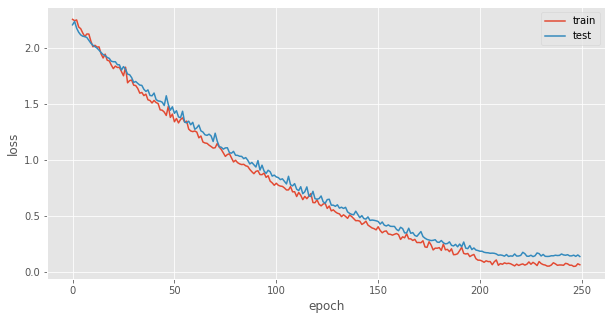

In [11]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 4.37
Best MAE: 3.41
Average RMSE: 5.89
Average MAE: 4.63


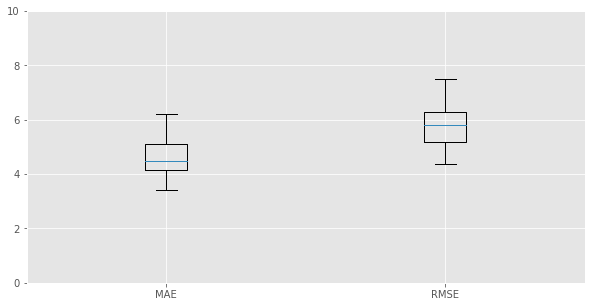

In [13]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim(0,10)
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

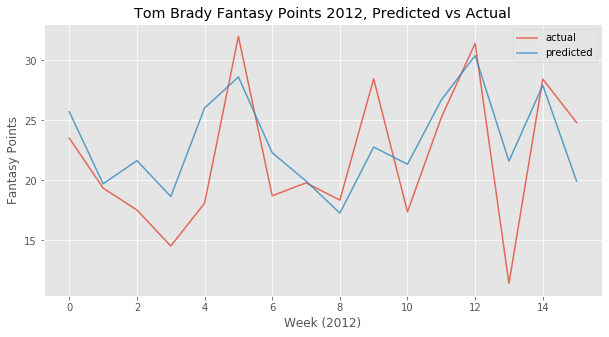

In [14]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

##### Iterative Training

In [20]:
# Remake training and test sets for iterative training
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [21]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(100, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), return_sequences=True, bias_regularizer=L1L2(0.01,0.01), stateful=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    n_iters = 250
    for k in range(n_iters):
        t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        print('Epoch {}/{}'.format(k+1, n_iters))
        print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
        
    gc.collect()
             

Epoch 1/250
14.62s
Epoch 2/250
0.16s
Epoch 3/250
0.17s
Epoch 4/250
0.19s
Epoch 5/250
0.17s
Epoch 6/250
0.16s
Epoch 7/250
0.17s
Epoch 8/250
0.16s
Epoch 9/250
0.17s
Epoch 10/250
0.17s
Epoch 11/250
0.18s
Epoch 12/250
0.16s
Epoch 13/250
0.17s
Epoch 14/250
0.17s
Epoch 15/250
0.17s
Epoch 16/250
0.16s
Epoch 17/250
0.16s
Epoch 18/250
0.16s
Epoch 19/250
0.16s
Epoch 20/250
0.16s
Epoch 21/250
0.16s
Epoch 22/250
0.16s
Epoch 23/250
0.16s
Epoch 24/250
0.16s
Epoch 25/250
0.16s
Epoch 26/250
0.16s
Epoch 27/250
0.15s
Epoch 28/250
0.15s
Epoch 29/250
0.16s
Epoch 30/250
0.15s
Epoch 31/250
0.15s
Epoch 32/250
0.15s
Epoch 33/250
0.17s
Epoch 34/250
0.18s
Epoch 35/250
0.16s
Epoch 36/250
0.15s
Epoch 37/250
0.15s
Epoch 38/250
0.15s
Epoch 39/250
0.15s
Epoch 40/250
0.14s
Epoch 41/250
0.12s
Epoch 42/250
0.12s
Epoch 43/250
0.16s
Epoch 44/250
0.15s
Epoch 45/250
0.14s
Epoch 46/250
0.12s
Epoch 47/250
0.12s
Epoch 48/250
0.12s
Epoch 49/250
0.12s
Epoch 50/250
0.11s
Epoch 51/250
0.12s
Epoch 52/250
0.12s
Epoch 53/250
0.12s
E

Epoch 172/250
0.15s
Epoch 173/250
0.15s
Epoch 174/250
0.14s
Epoch 175/250
0.12s
Epoch 176/250
0.14s
Epoch 177/250
0.13s
Epoch 178/250
0.13s
Epoch 179/250
0.15s
Epoch 180/250
0.17s
Epoch 181/250
0.13s
Epoch 182/250
0.16s
Epoch 183/250
0.18s
Epoch 184/250
0.13s
Epoch 185/250
0.20s
Epoch 186/250
0.14s
Epoch 187/250
0.13s
Epoch 188/250
0.13s
Epoch 189/250
0.14s
Epoch 190/250
0.16s
Epoch 191/250
0.12s
Epoch 192/250
0.14s
Epoch 193/250
0.13s
Epoch 194/250
0.14s
Epoch 195/250
0.13s
Epoch 196/250
0.13s
Epoch 197/250
0.14s
Epoch 198/250
0.12s
Epoch 199/250
0.14s
Epoch 200/250
0.13s
Epoch 201/250
0.15s
Epoch 202/250
0.13s
Epoch 203/250
0.15s
Epoch 204/250
0.16s
Epoch 205/250
0.15s
Epoch 206/250
0.11s
Epoch 207/250
0.12s
Epoch 208/250
0.13s
Epoch 209/250
0.14s
Epoch 210/250
0.13s
Epoch 211/250
0.14s
Epoch 212/250
0.15s
Epoch 213/250
0.12s
Epoch 214/250
0.15s
Epoch 215/250
0.14s
Epoch 216/250
0.14s
Epoch 217/250
0.12s
Epoch 218/250
0.13s
Epoch 219/250
0.13s
Epoch 220/250
0.13s
Epoch 221/250
0.13s


Epoch 92/250
0.10s
Epoch 93/250
0.11s
Epoch 94/250
0.11s
Epoch 95/250
0.11s
Epoch 96/250
0.11s
Epoch 97/250
0.11s
Epoch 98/250
0.10s
Epoch 99/250
0.10s
Epoch 100/250
0.10s
Epoch 101/250
0.11s
Epoch 102/250
0.10s
Epoch 103/250
0.09s
Epoch 104/250
0.10s
Epoch 105/250
0.10s
Epoch 106/250
0.10s
Epoch 107/250
0.10s
Epoch 108/250
0.10s
Epoch 109/250
0.10s
Epoch 110/250
0.10s
Epoch 111/250
0.10s
Epoch 112/250
0.10s
Epoch 113/250
0.10s
Epoch 114/250
0.10s
Epoch 115/250
0.11s
Epoch 116/250
0.10s
Epoch 117/250
0.10s
Epoch 118/250
0.10s
Epoch 119/250
0.10s
Epoch 120/250
0.09s
Epoch 121/250
0.10s
Epoch 122/250
0.10s
Epoch 123/250
0.10s
Epoch 124/250
0.10s
Epoch 125/250
0.10s
Epoch 126/250
0.10s
Epoch 127/250
0.10s
Epoch 128/250
0.10s
Epoch 129/250
0.10s
Epoch 130/250
0.11s
Epoch 131/250
0.10s
Epoch 132/250
0.09s
Epoch 133/250
0.11s
Epoch 134/250
0.10s
Epoch 135/250
0.10s
Epoch 136/250
0.09s
Epoch 137/250
0.09s
Epoch 138/250
0.12s
Epoch 139/250
0.10s
Epoch 140/250
0.09s
Epoch 141/250
0.10s
Epoch 14

Epoch 9/250
0.15s
Epoch 10/250
0.12s
Epoch 11/250
0.11s
Epoch 12/250
0.14s
Epoch 13/250
0.09s
Epoch 14/250
0.14s
Epoch 15/250
0.11s
Epoch 16/250
0.10s
Epoch 17/250
0.10s
Epoch 18/250
0.13s
Epoch 19/250
0.11s
Epoch 20/250
0.15s
Epoch 21/250
0.17s
Epoch 22/250
0.18s
Epoch 23/250
0.17s
Epoch 24/250
0.18s
Epoch 25/250
0.18s
Epoch 26/250
0.18s
Epoch 27/250
0.17s
Epoch 28/250
0.12s
Epoch 29/250
0.13s
Epoch 30/250
0.18s
Epoch 31/250
0.17s
Epoch 32/250
0.16s
Epoch 33/250
0.11s
Epoch 34/250
0.10s
Epoch 35/250
0.14s
Epoch 36/250
0.15s
Epoch 37/250
0.11s
Epoch 38/250
0.10s
Epoch 39/250
0.14s
Epoch 40/250
0.10s
Epoch 41/250
0.10s
Epoch 42/250
0.10s
Epoch 43/250
0.10s
Epoch 44/250
0.11s
Epoch 45/250
0.11s
Epoch 46/250
0.11s
Epoch 47/250
0.11s
Epoch 48/250
0.11s
Epoch 49/250
0.11s
Epoch 50/250
0.10s
Epoch 51/250
0.11s
Epoch 52/250
0.11s
Epoch 53/250
0.10s
Epoch 54/250
0.11s
Epoch 55/250
0.10s
Epoch 56/250
0.10s
Epoch 57/250
0.11s
Epoch 58/250
0.14s
Epoch 59/250
0.16s
Epoch 60/250
0.12s
Epoch 61/250


Epoch 179/250
0.14s
Epoch 180/250
0.13s
Epoch 181/250
0.13s
Epoch 182/250
0.13s
Epoch 183/250
0.13s
Epoch 184/250
0.13s
Epoch 185/250
0.13s
Epoch 186/250
0.13s
Epoch 187/250
0.13s
Epoch 188/250
0.13s
Epoch 189/250
0.13s
Epoch 190/250
0.13s
Epoch 191/250
0.14s
Epoch 192/250
0.13s
Epoch 193/250
0.13s
Epoch 194/250
0.13s
Epoch 195/250
0.13s
Epoch 196/250
0.13s
Epoch 197/250
0.13s
Epoch 198/250
0.13s
Epoch 199/250
0.13s
Epoch 200/250
0.13s
Epoch 201/250
0.13s
Epoch 202/250
0.13s
Epoch 203/250
0.13s
Epoch 204/250
0.13s
Epoch 205/250
0.13s
Epoch 206/250
0.13s
Epoch 207/250
0.14s
Epoch 208/250
0.14s
Epoch 209/250
0.14s
Epoch 210/250
0.14s
Epoch 211/250
0.14s
Epoch 212/250
0.13s
Epoch 213/250
0.14s
Epoch 214/250
0.14s
Epoch 215/250
0.14s
Epoch 216/250
0.14s
Epoch 217/250
0.14s
Epoch 218/250
0.13s
Epoch 219/250
0.14s
Epoch 220/250
0.13s
Epoch 221/250
0.14s
Epoch 222/250
0.14s
Epoch 223/250
0.13s
Epoch 224/250
0.13s
Epoch 225/250
0.13s
Epoch 226/250
0.13s
Epoch 227/250
0.13s
Epoch 228/250
0.13s


Epoch 101/250
0.12s
Epoch 102/250
0.12s
Epoch 103/250
0.13s
Epoch 104/250
0.11s
Epoch 105/250
0.12s
Epoch 106/250
0.12s
Epoch 107/250
0.12s
Epoch 108/250
0.11s
Epoch 109/250
0.12s
Epoch 110/250
0.12s
Epoch 111/250
0.13s
Epoch 112/250
0.12s
Epoch 113/250
0.12s
Epoch 114/250
0.12s
Epoch 115/250
0.13s
Epoch 116/250
0.12s
Epoch 117/250
0.15s
Epoch 118/250
0.11s
Epoch 119/250
0.12s
Epoch 120/250
0.11s
Epoch 121/250
0.12s
Epoch 122/250
0.12s
Epoch 123/250
0.13s
Epoch 124/250
0.11s
Epoch 125/250
0.12s
Epoch 126/250
0.12s
Epoch 127/250
0.12s
Epoch 128/250
0.12s
Epoch 129/250
0.12s
Epoch 130/250
0.13s
Epoch 131/250
0.16s
Epoch 132/250
0.12s
Epoch 133/250
0.12s
Epoch 134/250
0.11s
Epoch 135/250
0.12s
Epoch 136/250
0.12s
Epoch 137/250
0.13s
Epoch 138/250
0.12s
Epoch 139/250
0.12s
Epoch 140/250
0.11s
Epoch 141/250
0.12s
Epoch 142/250
0.12s
Epoch 143/250
0.14s
Epoch 144/250
0.13s
Epoch 145/250
0.13s
Epoch 146/250
0.14s
Epoch 147/250
0.14s
Epoch 148/250
0.11s
Epoch 149/250
0.13s
Epoch 150/250
0.13s


Epoch 19/250
0.15s
Epoch 20/250
0.15s
Epoch 21/250
0.15s
Epoch 22/250
0.15s
Epoch 23/250
0.14s
Epoch 24/250
0.15s
Epoch 25/250
0.14s
Epoch 26/250
0.14s
Epoch 27/250
0.15s
Epoch 28/250
0.15s
Epoch 29/250
0.15s
Epoch 30/250
0.14s
Epoch 31/250
0.15s
Epoch 32/250
0.16s
Epoch 33/250
0.15s
Epoch 34/250
0.15s
Epoch 35/250
0.15s
Epoch 36/250
0.15s
Epoch 37/250
0.15s
Epoch 38/250
0.15s
Epoch 39/250
0.15s
Epoch 40/250
0.14s
Epoch 41/250
0.15s
Epoch 42/250
0.14s
Epoch 43/250
0.14s
Epoch 44/250
0.15s
Epoch 45/250
0.14s
Epoch 46/250
0.15s
Epoch 47/250
0.15s
Epoch 48/250
0.14s
Epoch 49/250
0.14s
Epoch 50/250
0.15s
Epoch 51/250
0.14s
Epoch 52/250
0.14s
Epoch 53/250
0.15s
Epoch 54/250
0.14s
Epoch 55/250
0.15s
Epoch 56/250
0.14s
Epoch 57/250
0.15s
Epoch 58/250
0.14s
Epoch 59/250
0.15s
Epoch 60/250
0.14s
Epoch 61/250
0.14s
Epoch 62/250
0.14s
Epoch 63/250
0.14s
Epoch 64/250
0.14s
Epoch 65/250
0.14s
Epoch 66/250
0.14s
Epoch 67/250
0.14s
Epoch 68/250
0.13s
Epoch 69/250
0.12s
Epoch 70/250
0.12s
Epoch 71/250

Epoch 189/250
0.14s
Epoch 190/250
0.14s
Epoch 191/250
0.16s
Epoch 192/250
0.14s
Epoch 193/250
0.14s
Epoch 194/250
0.19s
Epoch 195/250
0.23s
Epoch 196/250
0.15s
Epoch 197/250
0.14s
Epoch 198/250
0.15s
Epoch 199/250
0.15s
Epoch 200/250
0.15s
Epoch 201/250
0.15s
Epoch 202/250
0.14s
Epoch 203/250
0.14s
Epoch 204/250
0.14s
Epoch 205/250
0.14s
Epoch 206/250
0.14s
Epoch 207/250
0.17s
Epoch 208/250
0.16s
Epoch 209/250
0.15s
Epoch 210/250
0.15s
Epoch 211/250
0.17s
Epoch 212/250
0.16s
Epoch 213/250
0.16s
Epoch 214/250
0.17s
Epoch 215/250
0.15s
Epoch 216/250
0.17s
Epoch 217/250
0.16s
Epoch 218/250
0.16s
Epoch 219/250
0.15s
Epoch 220/250
0.15s
Epoch 221/250
0.15s
Epoch 222/250
0.17s
Epoch 223/250
0.16s
Epoch 224/250
0.14s
Epoch 225/250
0.14s
Epoch 226/250
0.15s
Epoch 227/250
0.15s
Epoch 228/250
0.16s
Epoch 229/250
0.14s
Epoch 230/250
0.15s
Epoch 231/250
0.14s
Epoch 232/250
0.15s
Epoch 233/250
0.14s
Epoch 234/250
0.13s
Epoch 235/250
0.14s
Epoch 236/250
0.16s
Epoch 237/250
0.15s
Epoch 238/250
0.14s


Epoch 111/250
0.10s
Epoch 112/250
0.10s
Epoch 113/250
0.10s
Epoch 114/250
0.10s
Epoch 115/250
0.10s
Epoch 116/250
0.11s
Epoch 117/250
0.10s
Epoch 118/250
0.10s
Epoch 119/250
0.10s
Epoch 120/250
0.10s
Epoch 121/250
0.10s
Epoch 122/250
0.10s
Epoch 123/250
0.10s
Epoch 124/250
0.10s
Epoch 125/250
0.10s
Epoch 126/250
0.10s
Epoch 127/250
0.11s
Epoch 128/250
0.10s
Epoch 129/250
0.11s
Epoch 130/250
0.11s
Epoch 131/250
0.10s
Epoch 132/250
0.10s
Epoch 133/250
0.10s
Epoch 134/250
0.10s
Epoch 135/250
0.10s
Epoch 136/250
0.11s
Epoch 137/250
0.11s
Epoch 138/250
0.11s
Epoch 139/250
0.11s
Epoch 140/250
0.10s
Epoch 141/250
0.11s
Epoch 142/250
0.10s
Epoch 143/250
0.10s
Epoch 144/250
0.10s
Epoch 145/250
0.10s
Epoch 146/250
0.11s
Epoch 147/250
0.10s
Epoch 148/250
0.10s
Epoch 149/250
0.11s
Epoch 150/250
0.11s
Epoch 151/250
0.10s
Epoch 152/250
0.10s
Epoch 153/250
0.10s
Epoch 154/250
0.10s
Epoch 155/250
0.11s
Epoch 156/250
0.10s
Epoch 157/250
0.11s
Epoch 158/250
0.10s
Epoch 159/250
0.11s
Epoch 160/250
0.10s


Epoch 29/250
0.11s
Epoch 30/250
0.09s
Epoch 31/250
0.10s
Epoch 32/250
0.10s
Epoch 33/250
0.10s
Epoch 34/250
0.10s
Epoch 35/250
0.11s
Epoch 36/250
0.10s
Epoch 37/250
0.10s
Epoch 38/250
0.10s
Epoch 39/250
0.10s
Epoch 40/250
0.10s
Epoch 41/250
0.10s
Epoch 42/250
0.09s
Epoch 43/250
0.10s
Epoch 44/250
0.10s
Epoch 45/250
0.09s
Epoch 46/250
0.10s
Epoch 47/250
0.11s
Epoch 48/250
0.09s
Epoch 49/250
0.10s
Epoch 50/250
0.10s
Epoch 51/250
0.10s
Epoch 52/250
0.09s
Epoch 53/250
0.10s
Epoch 54/250
0.10s
Epoch 55/250
0.09s
Epoch 56/250
0.10s
Epoch 57/250
0.09s
Epoch 58/250
0.09s
Epoch 59/250
0.10s
Epoch 60/250
0.10s
Epoch 61/250
0.10s
Epoch 62/250
0.10s
Epoch 63/250
0.09s
Epoch 64/250
0.10s
Epoch 65/250
0.10s
Epoch 66/250
0.09s
Epoch 67/250
0.10s
Epoch 68/250
0.10s
Epoch 69/250
0.09s
Epoch 70/250
0.10s
Epoch 71/250
0.10s
Epoch 72/250
0.10s
Epoch 73/250
0.10s
Epoch 74/250
0.10s
Epoch 75/250
0.10s
Epoch 76/250
0.09s
Epoch 77/250
0.10s
Epoch 78/250
0.09s
Epoch 79/250
0.11s
Epoch 80/250
0.12s
Epoch 81/250

Epoch 200/250
0.11s
Epoch 201/250
0.10s
Epoch 202/250
0.10s
Epoch 203/250
0.11s
Epoch 204/250
0.10s
Epoch 205/250
0.13s
Epoch 206/250
0.11s
Epoch 207/250
0.10s
Epoch 208/250
0.10s
Epoch 209/250
0.11s
Epoch 210/250
0.10s
Epoch 211/250
0.10s
Epoch 212/250
0.10s
Epoch 213/250
0.10s
Epoch 214/250
0.10s
Epoch 215/250
0.10s
Epoch 216/250
0.10s
Epoch 217/250
0.10s
Epoch 218/250
0.10s
Epoch 219/250
0.10s
Epoch 220/250
0.10s
Epoch 221/250
0.10s
Epoch 222/250
0.10s
Epoch 223/250
0.10s
Epoch 224/250
0.10s
Epoch 225/250
0.10s
Epoch 226/250
0.10s
Epoch 227/250
0.11s
Epoch 228/250
0.10s
Epoch 229/250
0.10s
Epoch 230/250
0.11s
Epoch 231/250
0.10s
Epoch 232/250
0.10s
Epoch 233/250
0.10s
Epoch 234/250
0.10s
Epoch 235/250
0.10s
Epoch 236/250
0.11s
Epoch 237/250
0.10s
Epoch 238/250
0.10s
Epoch 239/250
0.10s
Epoch 240/250
0.10s
Epoch 241/250
0.10s
Epoch 242/250
0.10s
Epoch 243/250
0.10s
Epoch 244/250
0.10s
Epoch 245/250
0.10s
Epoch 246/250
0.10s
Epoch 247/250
0.10s
Epoch 248/250
0.10s
Epoch 249/250
0.10s


Epoch 121/250
0.10s
Epoch 122/250
0.09s
Epoch 123/250
0.10s
Epoch 124/250
0.10s
Epoch 125/250
0.10s
Epoch 126/250
0.10s
Epoch 127/250
0.10s
Epoch 128/250
0.10s
Epoch 129/250
0.10s
Epoch 130/250
0.10s
Epoch 131/250
0.10s
Epoch 132/250
0.10s
Epoch 133/250
0.10s
Epoch 134/250
0.10s
Epoch 135/250
0.09s
Epoch 136/250
0.10s
Epoch 137/250
0.10s
Epoch 138/250
0.10s
Epoch 139/250
0.10s
Epoch 140/250
0.09s
Epoch 141/250
0.10s
Epoch 142/250
0.10s
Epoch 143/250
0.10s
Epoch 144/250
0.10s
Epoch 145/250
0.10s
Epoch 146/250
0.09s
Epoch 147/250
0.10s
Epoch 148/250
0.10s
Epoch 149/250
0.10s
Epoch 150/250
0.10s
Epoch 151/250
0.10s
Epoch 152/250
0.10s
Epoch 153/250
0.09s
Epoch 154/250
0.10s
Epoch 155/250
0.09s
Epoch 156/250
0.10s
Epoch 157/250
0.10s
Epoch 158/250
0.10s
Epoch 159/250
0.09s
Epoch 160/250
0.10s
Epoch 161/250
0.09s
Epoch 162/250
0.10s
Epoch 163/250
0.10s
Epoch 164/250
0.10s
Epoch 165/250
0.10s
Epoch 166/250
0.10s
Epoch 167/250
0.09s
Epoch 168/250
0.10s
Epoch 169/250
0.10s
Epoch 170/250
0.10s


Epoch 39/250
0.11s
Epoch 40/250
0.13s
Epoch 41/250
0.13s
Epoch 42/250
0.12s
Epoch 43/250
0.12s
Epoch 44/250
0.12s
Epoch 45/250
0.12s
Epoch 46/250
0.11s
Epoch 47/250
0.11s
Epoch 48/250
0.11s
Epoch 49/250
0.12s
Epoch 50/250
0.11s
Epoch 51/250
0.11s
Epoch 52/250
0.11s
Epoch 53/250
0.11s
Epoch 54/250
0.13s
Epoch 55/250
0.13s
Epoch 56/250
0.11s
Epoch 57/250
0.11s
Epoch 58/250
0.12s
Epoch 59/250
0.11s
Epoch 60/250
0.12s
Epoch 61/250
0.11s
Epoch 62/250
0.11s
Epoch 63/250
0.11s
Epoch 64/250
0.13s
Epoch 65/250
0.12s
Epoch 66/250
0.11s
Epoch 67/250
0.10s
Epoch 68/250
0.11s
Epoch 69/250
0.12s
Epoch 70/250
0.13s
Epoch 71/250
0.11s
Epoch 72/250
0.10s
Epoch 73/250
0.10s
Epoch 74/250
0.11s
Epoch 75/250
0.12s
Epoch 76/250
0.10s
Epoch 77/250
0.11s
Epoch 78/250
0.11s
Epoch 79/250
0.11s
Epoch 80/250
0.11s
Epoch 81/250
0.12s
Epoch 82/250
0.12s
Epoch 83/250
0.11s
Epoch 84/250
0.11s
Epoch 85/250
0.11s
Epoch 86/250
0.11s
Epoch 87/250
0.11s
Epoch 88/250
0.13s
Epoch 89/250
0.13s
Epoch 90/250
0.10s
Epoch 91/250

Epoch 209/250
0.10s
Epoch 210/250
0.12s
Epoch 211/250
0.15s
Epoch 212/250
0.11s
Epoch 213/250
0.10s
Epoch 214/250
0.12s
Epoch 215/250
0.12s
Epoch 216/250
0.12s
Epoch 217/250
0.13s
Epoch 218/250
0.11s
Epoch 219/250
0.11s
Epoch 220/250
0.12s
Epoch 221/250
0.12s
Epoch 222/250
0.11s
Epoch 223/250
0.10s
Epoch 224/250
0.10s
Epoch 225/250
0.13s
Epoch 226/250
0.15s
Epoch 227/250
0.10s
Epoch 228/250
0.10s
Epoch 229/250
0.11s
Epoch 230/250
0.10s
Epoch 231/250
0.11s
Epoch 232/250
0.10s
Epoch 233/250
0.14s
Epoch 234/250
0.16s
Epoch 235/250
0.10s
Epoch 236/250
0.10s
Epoch 237/250
0.12s
Epoch 238/250
0.12s
Epoch 239/250
0.13s
Epoch 240/250
0.16s
Epoch 241/250
0.16s
Epoch 242/250
0.11s
Epoch 243/250
0.11s
Epoch 244/250
0.10s
Epoch 245/250
0.10s
Epoch 246/250
0.10s
Epoch 247/250
0.11s
Epoch 248/250
0.16s
Epoch 249/250
0.12s
Epoch 250/250
0.12s
Epoch 1/250
19.13s
Epoch 2/250
0.13s
Epoch 3/250
0.12s
Epoch 4/250
0.15s
Epoch 5/250
0.15s
Epoch 6/250
0.11s
Epoch 7/250
0.11s
Epoch 8/250
0.13s
Epoch 9/250
0.1

Epoch 131/250
0.13s
Epoch 132/250
0.10s
Epoch 133/250
0.09s
Epoch 134/250
0.10s
Epoch 135/250
0.13s
Epoch 136/250
0.16s
Epoch 137/250
0.10s
Epoch 138/250
0.11s
Epoch 139/250
0.12s
Epoch 140/250
0.14s
Epoch 141/250
0.17s
Epoch 142/250
0.17s
Epoch 143/250
0.16s
Epoch 144/250
0.13s
Epoch 145/250
0.15s
Epoch 146/250
0.12s
Epoch 147/250
0.15s
Epoch 148/250
0.13s
Epoch 149/250
0.10s
Epoch 150/250
0.10s
Epoch 151/250
0.10s
Epoch 152/250
0.10s
Epoch 153/250
0.10s
Epoch 154/250
0.11s
Epoch 155/250
0.12s
Epoch 156/250
0.15s
Epoch 157/250
0.11s
Epoch 158/250
0.10s
Epoch 159/250
0.10s
Epoch 160/250
0.10s
Epoch 161/250
0.10s
Epoch 162/250
0.11s
Epoch 163/250
0.11s
Epoch 164/250
0.11s
Epoch 165/250
0.11s
Epoch 166/250
0.11s
Epoch 167/250
0.11s
Epoch 168/250
0.11s
Epoch 169/250
0.10s
Epoch 170/250
0.11s
Epoch 171/250
0.10s
Epoch 172/250
0.10s
Epoch 173/250
0.10s
Epoch 174/250
0.10s
Epoch 175/250
0.13s
Epoch 176/250
0.14s
Epoch 177/250
0.17s
Epoch 178/250
0.17s
Epoch 179/250
0.14s
Epoch 180/250
0.14s


In [23]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 6.22
Best MAE: 4.94
Average RMSE: 6.73
Average MAE: 5.42


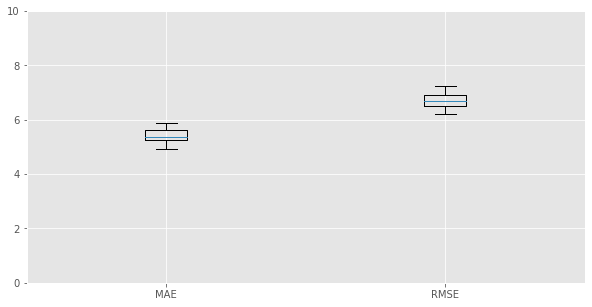

In [24]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

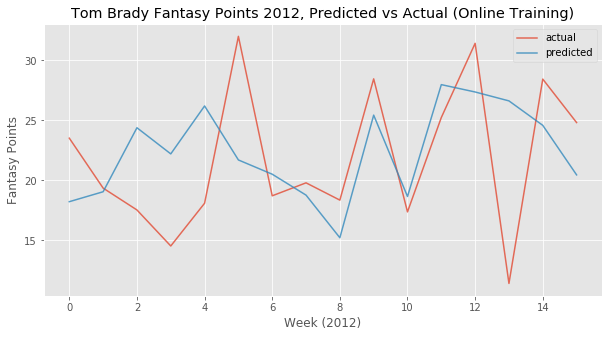

In [25]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

## LeSean McCoy

In [9]:
# Read in data
mccoy = pd.read_csv('../data/data_final/final/features_raw/mccoy.csv')
mccoy = mccoy.loc[:, features]
mccoy['date'] = pd.to_datetime(mccoy['date'])
mccoy = replace_nans_mean(mccoy, split_date)

In [10]:
# Train + test set indices
mccoy_played_only = mccoy.loc[mccoy['player_played']==1].copy().reset_index(drop=True)
train_idx = mccoy_played_only.loc[mccoy['date']<split_date].index.values
test_idx = mccoy_played_only.loc[mccoy_played_only['date']>split_date].index.values

# Scale Features
mccoy.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(mccoy)
mccoy = scaler.transform(mccoy)

# Train + test sets
train, test = mccoy[train_idx], mccoy[test_idx]

In [11]:
# Create train and test sets
window = 2

X, y = build_lstm_data(mccoy, window)
X = X[y!=0] # Keep games not played for time series, but do not make predictions
y = y[y!=0]

X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [12]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [29]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=20, batch_size=3, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()


Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.4822 - val_loss: 0.2484
Epoch 2/20
 - 0s - loss: 0.3416 - val_loss: 0.1110
Epoch 3/20
 - 0s - loss: 0.2268 - val_loss: 0.1113
Epoch 4/20
 - 0s - loss: 0.1885 - val_loss: 0.1507
Epoch 5/20
 - 0s - loss: 0.1954 - val_loss: 0.1573
Epoch 6/20
 - 0s - loss: 0.2089 - val_loss: 0.1506
Epoch 7/20
 - 0s - loss: 0.2053 - val_loss: 0.1364
Epoch 8/20
 - 0s - loss: 0.1963 - val_loss: 0.1255
Epoch 9/20
 - 0s - loss: 0.1948 - val_loss: 0.1173
Epoch 10/20
 - 0s - loss: 0.1728 - val_loss: 0.1311
Epoch 11/20
 - 0s - loss: 0.1711 - val_loss: 0.1696
Epoch 12/20
 - 0s - loss: 0.1935 - val_loss: 0.1802
Epoch 13/20
 - 0s - loss: 0.2138 - val_loss: 0.1430
Epoch 14/20
 - 0s - loss: 0.2168 - val_loss: 0.1153
Epoch 15/20
 - 0s - loss: 0.1722 - val_loss: 0.1370
Epoch 16/20
 - 0s - loss: 0.1870 - val_loss: 0.1680
Epoch 17/20
 - 0s - loss: 0.2321 - val_loss: 0.1482
Epoch 18/20
 - 0s - loss: 0.2120 - val_loss: 0.1524
Epoch 19/20
 - 0s - loss: 0.1

 - 0s - loss: 0.1662 - val_loss: 0.1222
Epoch 14/20
 - 0s - loss: 0.2122 - val_loss: 0.1058
Epoch 15/20
 - 0s - loss: 0.1849 - val_loss: 0.1040
Epoch 16/20
 - 0s - loss: 0.2006 - val_loss: 0.1147
Epoch 17/20
 - 0s - loss: 0.2067 - val_loss: 0.1461
Epoch 18/20
 - 0s - loss: 0.2034 - val_loss: 0.1557
Epoch 19/20
 - 0s - loss: 0.2025 - val_loss: 0.1353
Epoch 20/20
 - 0s - loss: 0.1746 - val_loss: 0.1395
Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.3985 - val_loss: 0.1699
Epoch 2/20
 - 0s - loss: 0.2679 - val_loss: 0.0879
Epoch 3/20
 - 0s - loss: 0.2049 - val_loss: 0.1776
Epoch 4/20
 - 0s - loss: 0.1840 - val_loss: 0.1729
Epoch 5/20
 - 0s - loss: 0.2175 - val_loss: 0.1174
Epoch 6/20
 - 0s - loss: 0.2090 - val_loss: 0.0909
Epoch 7/20
 - 0s - loss: 0.2007 - val_loss: 0.1004
Epoch 8/20
 - 0s - loss: 0.1908 - val_loss: 0.1065
Epoch 9/20
 - 0s - loss: 0.2020 - val_loss: 0.1282
Epoch 10/20
 - 0s - loss: 0.2002 - val_loss: 0.1354
Epoch 11/20
 - 0s - loss: 0.1908 - val_lo

Epoch 6/20
 - 0s - loss: 0.1985 - val_loss: 0.1233
Epoch 7/20
 - 0s - loss: 0.1944 - val_loss: 0.1026
Epoch 8/20
 - 0s - loss: 0.1970 - val_loss: 0.0989
Epoch 9/20
 - 0s - loss: 0.2247 - val_loss: 0.0937
Epoch 10/20
 - 0s - loss: 0.2105 - val_loss: 0.0982
Epoch 11/20
 - 0s - loss: 0.2068 - val_loss: 0.1063
Epoch 12/20
 - 0s - loss: 0.2068 - val_loss: 0.1242
Epoch 13/20
 - 0s - loss: 0.1835 - val_loss: 0.1367
Epoch 14/20
 - 0s - loss: 0.2066 - val_loss: 0.1429
Epoch 15/20
 - 0s - loss: 0.1872 - val_loss: 0.1284
Epoch 16/20
 - 0s - loss: 0.1616 - val_loss: 0.1145
Epoch 17/20
 - 0s - loss: 0.1890 - val_loss: 0.1176
Epoch 18/20
 - 0s - loss: 0.2062 - val_loss: 0.1168
Epoch 19/20
 - 0s - loss: 0.1903 - val_loss: 0.1173
Epoch 20/20
 - 0s - loss: 0.1745 - val_loss: 0.1265
Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.4897 - val_loss: 0.2727
Epoch 2/20
 - 0s - loss: 0.3618 - val_loss: 0.1348
Epoch 3/20
 - 0s - loss: 0.2466 - val_loss: 0.0731
Epoch 4/20
 - 0s - loss: 0.

Epoch 19/20
 - 0s - loss: 0.1808 - val_loss: 0.1356
Epoch 20/20
 - 0s - loss: 0.1974 - val_loss: 0.1231
Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.3680 - val_loss: 0.1120
Epoch 2/20
 - 0s - loss: 0.2326 - val_loss: 0.1040
Epoch 3/20
 - 0s - loss: 0.2468 - val_loss: 0.1322
Epoch 4/20
 - 0s - loss: 0.2231 - val_loss: 0.1246
Epoch 5/20
 - 0s - loss: 0.2327 - val_loss: 0.1128
Epoch 6/20
 - 0s - loss: 0.2299 - val_loss: 0.0968
Epoch 7/20
 - 0s - loss: 0.2108 - val_loss: 0.0919
Epoch 8/20
 - 0s - loss: 0.2083 - val_loss: 0.1097
Epoch 9/20
 - 0s - loss: 0.1841 - val_loss: 0.1374
Epoch 10/20
 - 0s - loss: 0.2455 - val_loss: 0.0959
Epoch 11/20
 - 0s - loss: 0.2104 - val_loss: 0.0899
Epoch 12/20
 - 0s - loss: 0.1887 - val_loss: 0.1065
Epoch 13/20
 - 0s - loss: 0.2234 - val_loss: 0.1257
Epoch 14/20
 - 0s - loss: 0.1820 - val_loss: 0.1592
Epoch 15/20
 - 0s - loss: 0.2151 - val_loss: 0.1596
Epoch 16/20
 - 0s - loss: 0.2044 - val_loss: 0.1348
Epoch 17/20
 - 0s - loss: 0.2

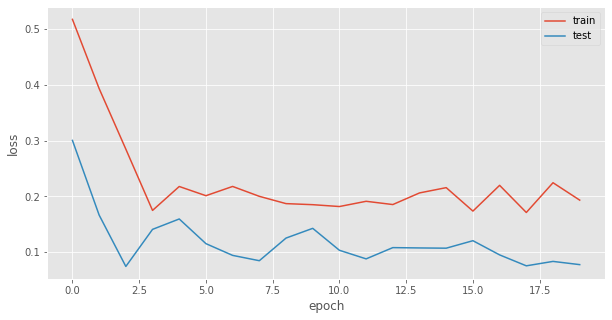

In [30]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [31]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 3.28
Best MAE: 2.48
Average RMSE: 4.69
Average MAE: 4.02


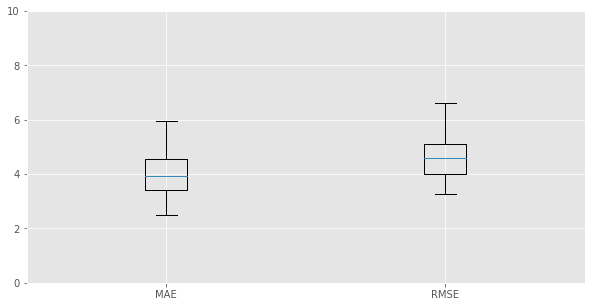

In [32]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

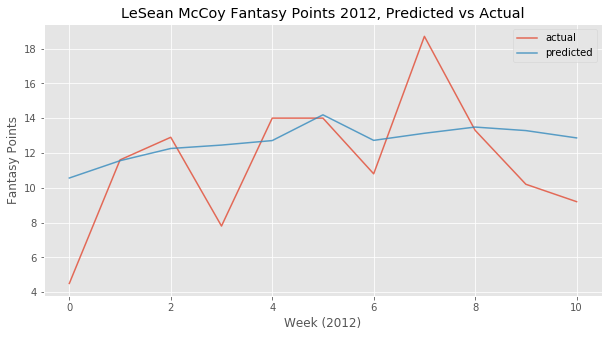

In [33]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

#### Online Training

In [13]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    n_iters = 20
    for k in range(n_iters):
        t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        print('Epoch {}/{}'.format(k+1, n_iters))
        print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
        
    gc.collect()
             

Epoch 1/20
2.48s
Epoch 2/20
0.10s
Epoch 3/20
0.10s
Epoch 4/20
0.10s
Epoch 5/20
0.08s
Epoch 6/20
0.07s
Epoch 7/20
0.08s
Epoch 8/20
0.07s
Epoch 9/20
0.10s
Epoch 10/20
0.10s
Epoch 11/20
0.09s
Epoch 12/20
0.09s
Epoch 13/20
0.11s
Epoch 14/20
0.13s
Epoch 15/20
0.10s
Epoch 16/20
0.10s
Epoch 17/20
0.11s
Epoch 18/20
0.10s
Epoch 19/20
0.09s
Epoch 20/20
0.13s
Epoch 1/20
2.86s
Epoch 2/20
0.12s
Epoch 3/20
0.11s
Epoch 4/20
0.09s
Epoch 5/20
0.11s
Epoch 6/20
0.12s
Epoch 7/20
0.11s
Epoch 8/20
0.11s
Epoch 9/20
0.08s
Epoch 10/20
0.09s
Epoch 11/20
0.11s
Epoch 12/20
0.10s
Epoch 13/20
0.09s
Epoch 14/20
0.08s
Epoch 15/20
0.07s
Epoch 16/20
0.07s
Epoch 17/20
0.07s
Epoch 18/20
0.08s
Epoch 19/20
0.07s
Epoch 20/20
0.07s
Epoch 1/20
2.58s
Epoch 2/20
0.09s
Epoch 3/20
0.10s
Epoch 4/20
0.11s
Epoch 5/20
0.08s
Epoch 6/20
0.08s
Epoch 7/20
0.07s
Epoch 8/20
0.07s
Epoch 9/20
0.07s
Epoch 10/20
0.07s
Epoch 11/20
0.07s
Epoch 12/20
0.07s
Epoch 13/20
0.07s
Epoch 14/20
0.07s
Epoch 15/20
0.07s
Epoch 16/20
0.09s
Epoch 17/20
0.08s
E

Epoch 9/20
0.09s
Epoch 10/20
0.09s
Epoch 11/20
0.10s
Epoch 12/20
0.10s
Epoch 13/20
0.09s
Epoch 14/20
0.10s
Epoch 15/20
0.09s
Epoch 16/20
0.09s
Epoch 17/20
0.10s
Epoch 18/20
0.10s
Epoch 19/20
0.10s
Epoch 20/20
0.09s
Epoch 1/20
9.08s
Epoch 2/20
0.10s
Epoch 3/20
0.10s
Epoch 4/20
0.09s
Epoch 5/20
0.09s
Epoch 6/20
0.09s
Epoch 7/20
0.09s
Epoch 8/20
0.08s
Epoch 9/20
0.08s
Epoch 10/20
0.08s
Epoch 11/20
0.08s
Epoch 12/20
0.08s
Epoch 13/20
0.08s
Epoch 14/20
0.08s
Epoch 15/20
0.08s
Epoch 16/20
0.08s
Epoch 17/20
0.07s
Epoch 18/20
0.08s
Epoch 19/20
0.08s
Epoch 20/20
0.07s
CPU times: user 11min 19s, sys: 1min 49s, total: 13min 8s
Wall time: 7min 29s


In [14]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 6.68
Best MAE: 5.32
Average RMSE: 7.43
Average MAE: 6.08


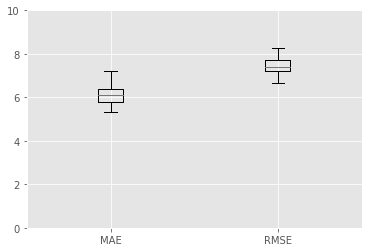

In [15]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

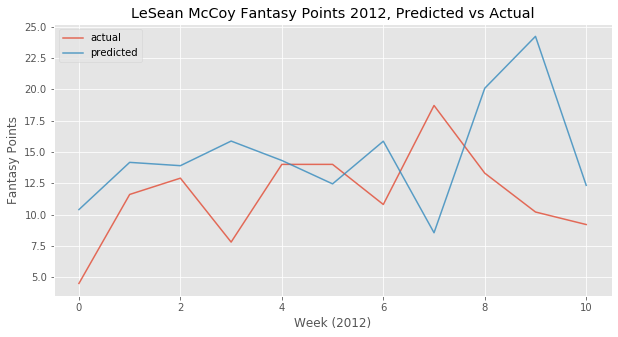

In [16]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')